<a href="https://colab.research.google.com/github/ZacharyZekaiXu/ZekaiXu_CrossmodalRecognition/blob/main/ZX_BeeCrossmodalTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bee_Tactile-Visual_Crossmodality_RL-Task

Zekai Xu, Impeiral College

### I. Reference

### II. Updates and To-Do-List







In [18]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install mujoco-py
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremo

In [2]:
!python --version
!pip install free-mujoco-py

Python 3.7.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install safety-gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement safety-gym (from versions: none)
ERROR: No matching distribution found for safety-gym


In [4]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym
!pip install free-mujoco-py
import mujoco_py
import gym

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.0.0-5).
libgl1-mesa-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
libosmesa6-dev is already the newest version (20.0.8-0ubuntu1~18.04.1).
software-properties-common is already the newest version (0.96.24.32.18).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexe

In [5]:
from google.colab import drive
drive.mount('/content/zxdrive')

%cd zxdrive/MyDrive/BeeCrossmodalityPJ/safety-gym
!git pull

Drive already mounted at /content/zxdrive; to attempt to forcibly remount, call drive.mount("/content/zxdrive", force_remount=True).
/content/zxdrive/MyDrive/BeeCrossmodalityPJ/safety-gym
Already up to date.


In [55]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

### Installing `dm_control` on Colab

In [22]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
!pip install -q dm_control>=1.0.5

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

RuntimeError: ignored

# Imports

Run both of these cells:

In [23]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [24]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

# Model definition, compilation and rendering



Here are some basic concepts of the [MuJoCo](http://mujoco.org/) physics simulation library, recommend the [official documentation](http://mujoco.org/book/) for details.

### Model Settings

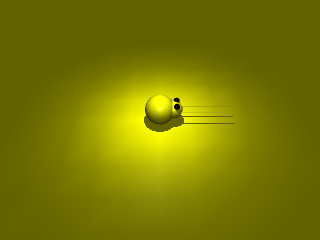

In [25]:
#@title {vertical-output: true}
bee_pointmodel = """
<mujoco>
    <size njmax="3000" nconmax="1000"/>
    <option timestep="0.002"/>
    <default>
        <geom condim="6" density="1" rgba="1 1 0 1"/>
        <joint damping=".001"/>
        <motor ctrlrange="-1 1" ctrllimited="true" forcerange="-.05 .05" forcelimited="true"/>
        <velocity ctrlrange="-1 1" ctrllimited="true" forcerange="-.05 .05" forcelimited="true"/>
        <site size="0.032" type="sphere"/>
    </default>
    <worldbody>-
        <light name="toplight" pos="0 0 1"/>
        <geom name="floor" size="5 5 0.1" type="plane" condim="6"/>
        <body name="robot" pos="0 0 .1">
            <camera name="vision1" pos="0 0 .15" xyaxes="0 -1 0 .4 0 1" fovy="90"/>
            <!-- <geom name="camera" pos="-.2 0 0" type="sphere" size=".05"/> -->
            <joint type="slide" axis="1 0 0" name="x" damping="0.01"/>
            <joint type="slide" axis="0 1 0" name="y" damping="0.01"/>
            <joint type="hinge" axis="0 0 1" name="z" damping="0.005"/>
            <geom name="robot" type="sphere" size=".1" friction="1 0.01 0.01"/>
            <geom name="beehead" pos="0.09 0 0" size="0.06" type="sphere" density = "0"/>
            <geom name="beewhister1" type="cylinder"  size="0.004 .8" fromto="0.1 -.03 0 0.5 -.03 0"/>
            <geom name="beewhister2" type="cylinder"  size="0.004 .8" fromto="0.1 .03 0 0.5 .03 0"/>
            <geom name="beeeye1" type="sphere" size=".02" pos=".11 -.03 0.05" rgba="0 0 0 1"/>
            <geom name="beeeye2" type="sphere" size=".02" pos=".11 0.03 0.05" rgba = "0 0 0 1"/>
            <site name="robot" rgba="1 0 0 .1"/>
        </body>
    </worldbody>
    <sensor>
        <!-- Used for observation -->
        <accelerometer site="robot" name="accelerometer"/>
        <velocimeter site="robot" name="velocimeter"/>
        <gyro site="robot" name="gyro"/>
        <magnetometer site="robot" name="magnetometer"/>
        <!-- Used for intrinsic constraints -->
        <subtreecom body="robot" name="subtreecom"/>
        <subtreelinvel body="robot" name="subtreelinvel"/>
        <subtreeangmom body="robot" name="subtreeangmom"/>
    </sensor>
    <actuator>
        <motor gear="0.3 0 0 0 0 0" site="robot" name="x"/>
        <velocity gear="0.3" jointinparent="z" name="z"/>
    </actuator>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(bee_pointmodel)
pixels = physics.render()
PIL.Image.fromarray(pixels)

`static_model` is written in MuJoCo's XML-based [MJCF](http://www.mujoco.org/book/modeling.html) modeling language. The `from_xml_string()` method invokes the model compiler, which instantiates the library's internal data structures. These can be accessed via the `physics` object, see below.

In [26]:
#@title Making a video {vertical-output: true}

duration = 2    # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = False

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
  physics.step()
  if len(frames) < physics.data.time * framerate:
    pixels = physics.render(scene_option=scene_option)
    frames.append(pixels)
display_video(frames, framerate)

Note how we collect the video frames. Because physics simulation timesteps are generally much smaller than framerates (the default timestep is 2ms), we don't render after each step.

### Rendering options

additional rendering options are exposed as parameters to the `render` method.

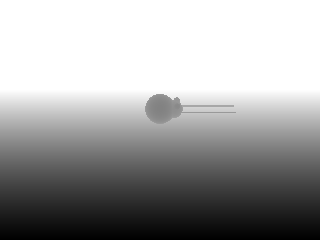

In [27]:
#@title Depth rendering {vertical-output: true}

# depth is a float array, in meters.
depth = physics.render(depth=True)
# Shift nearest values to the origin.
depth -= depth.min()
# Scale by 2 mean distances of near rays.
depth /= 2*depth[depth <= 1].mean()
# Scale to [0, 255]
pixels = 255*np.clip(depth, 0, 1)
PIL.Image.fromarray(pixels.astype(np.uint8))

## Other Objects in Task

In [11]:
!pip install git+https://github.com/openai/safety-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/safety-gym.git to /tmp/pip-req-build-4x2_5qta
  Running command git clone -q https://github.com/openai/safety-gym.git /tmp/pip-req-build-4x2_5qta
  Using cached gym-0.15.7-py3-none-any.whl
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached mujoco-py-2.0.2.7.tar.gz (777 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached numpy-1.17.5-cp37-cp37m-manylinux1_x86_64.whl (20.0 MB)
  Using cached xmltodict-0.12.0-py2.py3-none-any.whl (9.2 kB)
  Using cached cloudpickle-1.2.2-py2.py3-none-any.whl (25 kB)
  Created wheel for safety-gym: filename=safety_gym-0.0.0-py3-none-any.whl size=2722 sha256=ccb2a377073194754d832a8a0be8771c75887ac77cb3b14a162c29bad42e8b10
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [16]:
import safety_gym

In [19]:
import gym

env = gym.make('Safexp-PointGoal1-v0')

## Setting the state with `reset_context()`

In order for `data` quantities that are functions of the state to be in sync with the state, MuJoCo's `mj_step1()` needs to be called. This is facilitated by the `reset_context()` context, please see in-depth discussion in Section 2.1 of the [tech report](https://arxiv.org/abs/2006.12983).

# RL Environment: custom environment of OpenAI Safety Gym

### Class: World, Robot


In [28]:
def convert(v):
    ''' Convert a value into a string for mujoco XML '''
    if isinstance(v, (int, float, str)):
        return str(v)
    # Numpy arrays and lists
    return ' '.join(str(i) for i in np.asarray(v))


def rot2quat(theta):
    ''' Get a quaternion rotated only about the Z axis '''
    return np.array([np.cos(theta / 2), 0, 0, np.sin(theta / 2)], dtype='float64')

In [29]:
class World:
    DEFAULT = {
        'robot_base': 'xmls/point.xml',
        'robot_xy': np.zeros(2),  # Robot XY location
        'robot_rot': 0,  # Robot rotation about Z axis

        'floor_size': [3.5, 3.5, .1],  # Used for displaying the floor

        # Objects -- this is processed and added by the Engine class
        'objects': {},  # map from name -> object dict
        # Geoms -- similar to objects, but they are immovable and fixed in the scene.
        'geoms': {},  # map from name -> geom dict
        # Mocaps -- mocap objects which are used to control other objects
        'mocaps': {},

        # Determine whether we create render contexts
        'observe_vision': True,
    }

    def __init__(self, config={}, render_context=None):
        ''' config - JSON string or dict of configuration.  See self.parse() '''
        self.parse(config)  # Parse configuration
        self.first_reset = True
        self.viewer = None
        self.render_context = render_context
        self.update_viewer_sim = False
        self.robot = Robot(self.robot_base)

    def parse(self, config):
        ''' Parse a config dict - see self.DEFAULT for description '''
        self.config = deepcopy(self.DEFAULT)
        self.config.update(deepcopy(config))
        for key, value in self.config.items():
            assert key in self.DEFAULT, f'Bad key {key}'
            setattr(self, key, value)

    @property
    def data(self):
        ''' Helper to get the simulation data instance '''
        return self.sim.data

    # TODO: remove this when mujoco-py fix is merged and a new version is pushed
    # https://github.com/openai/mujoco-py/pull/354
    # Then all uses of `self.world.get_sensor()` should change to `self.data.get_sensor`.
    def get_sensor(self, name):
        id = self.model.sensor_name2id(name)
        adr = self.model.sensor_adr[id]
        dim = self.model.sensor_dim[id]
        return self.data.sensordata[adr:adr + dim].copy()

    def build(self):
        ''' Build a world, including generating XML and moving objects '''
        # Read in the base XML (contains robot, camera, floor, etc)
        self.robot_base_path = os.path.join(BASE_DIR, self.robot_base)
        with open(self.robot_base_path) as f:
            self.robot_base_xml = f.read()
        self.xml = xmltodict.parse(self.robot_base_xml)  # Nested OrderedDict objects

        # Convenience accessor for xml dictionary
        worldbody = self.xml['mujoco']['worldbody']

        # Move robot position to starting position
        worldbody['body']['@pos'] = convert(np.r_[self.robot_xy, self.robot.z_height])
        worldbody['body']['@quat'] = convert(rot2quat(self.robot_rot))

        # We need this because xmltodict skips over single-item lists in the tree
        worldbody['body'] = [worldbody['body']]
        if 'geom' in worldbody:
            worldbody['geom'] = [worldbody['geom']]
        else:
            worldbody['geom'] = []

        # Add equality section if missing
        if 'equality' not in self.xml['mujoco']:
            self.xml['mujoco']['equality'] = OrderedDict()
        equality = self.xml['mujoco']['equality']
        if 'weld' not in equality:
            equality['weld'] = []

        # Add asset section if missing
        if 'asset' not in self.xml['mujoco']:
            # old default rgb1: ".4 .5 .6"
            # old default rgb2: "0 0 0"
            # light pink: "1 0.44 .81"
            # light blue: "0.004 0.804 .996"
            # light purple: ".676 .547 .996"
            # med blue: "0.527 0.582 0.906"
            # indigo: "0.293 0 0.508"
            asset = xmltodict.parse('''
                <asset>
                    <texture type="skybox" builtin="gradient" rgb1="0.527 0.582 0.906" rgb2="0.1 0.1 0.35"
                        width="800" height="800" markrgb="1 1 1" mark="random" random="0.001"/>
                    <texture name="texplane" builtin="checker" height="100" width="100"
                        rgb1="0.7 0.7 0.7" rgb2="0.8 0.8 0.8" type="2d"/>
                    <material name="MatPlane" reflectance="0.1" shininess="0.1" specular="0.1"
                        texrepeat="10 10" texture="texplane"/>
                </asset>
                ''')
            self.xml['mujoco']['asset'] = asset['asset']


        # Add light to the XML dictionary
        light = xmltodict.parse('''<b>
            <light cutoff="100" diffuse="1 1 1" dir="0 0 -1" directional="true"
                exponent="1" pos="0 0 0.5" specular="0 0 0" castshadow="false"/>
            </b>''')
        worldbody['light'] = light['b']['light']

        # Add floor to the XML dictionary if missing
        if not any(g.get('@name') == 'floor' for g in worldbody['geom']):
            floor = xmltodict.parse('''
                <geom name="floor" type="plane" condim="6"/>
                ''')
            worldbody['geom'].append(floor['geom'])

        # Make sure floor renders the same for every world
        for g in worldbody['geom']:
            if g['@name'] == 'floor':
                g.update({'@size': convert(self.floor_size), '@rgba': '1 1 1 1', '@material': 'MatPlane'})

        # Add cameras to the XML dictionary
        cameras = xmltodict.parse('''<b>
            <camera name="fixednear" pos="0 -2 2" zaxis="0 -1 1"/>
            <camera name="fixedfar" pos="0 -5 5" zaxis="0 -1 1"/>
            </b>''')
        worldbody['camera'] = cameras['b']['camera']

        # Build and add a tracking camera (logic needed to ensure orientation correct)
        theta = self.robot_rot
        xyaxes = dict(
                    x1=np.cos(theta), 
                    x2=-np.sin(theta),
                    x3=0,
                    y1=np.sin(theta),
                    y2=np.cos(theta),
                    y3=1
                    )
        pos = dict(
                xp=0*np.cos(theta) + (-2)*np.sin(theta),
                yp=0*(-np.sin(theta)) + (-2)*np.cos(theta),
                zp=2
                )
        track_camera = xmltodict.parse('''<b>
            <camera name="track" mode="track" pos="{xp} {yp} {zp}" xyaxes="{x1} {x2} {x3} {y1} {y2} {y3}"/>
            </b>'''.format(**pos, **xyaxes))
        worldbody['body'][0]['camera'] = [
            worldbody['body'][0]['camera'],
            track_camera['b']['camera']
            ]


        # Add objects to the XML dictionary
        for name, object in self.objects.items():
            assert object['name'] == name, f'Inconsistent {name} {object}'
            object = object.copy()  # don't modify original object
            object['quat'] = rot2quat(object['rot'])
            if name=='box':
                dim = object['size'][0]
                object['dim'] = dim
                object['width'] = dim/2
                object['x'] = dim
                object['y'] = dim
                body = xmltodict.parse('''
                    <body name="{name}" pos="{pos}" quat="{quat}">
                        <freejoint name="{name}"/>
                        <geom name="{name}" type="{type}" size="{size}" density="{density}"
                            rgba="{rgba}" group="{group}"/>
                        <geom name="col1" type="{type}" size="{width} {width} {dim}" density="{density}"
                            rgba="{rgba}" group="{group}" pos="{x} {y} 0"/>
                        <geom name="col2" type="{type}" size="{width} {width} {dim}" density="{density}"
                            rgba="{rgba}" group="{group}" pos="-{x} {y} 0"/>
                        <geom name="col3" type="{type}" size="{width} {width} {dim}" density="{density}"
                            rgba="{rgba}" group="{group}" pos="{x} -{y} 0"/>
                        <geom name="col4" type="{type}" size="{width} {width} {dim}" density="{density}"
                            rgba="{rgba}" group="{group}" pos="-{x} -{y} 0"/>
                    </body>
                '''.format(**{k: convert(v) for k, v in object.items()}))
            else:
                body = xmltodict.parse('''
                    <body name="{name}" pos="{pos}" quat="{quat}">
                        <freejoint name="{name}"/>
                        <geom name="{name}" type="{type}" size="{size}" density="{density}"
                            rgba="{rgba}" group="{group}"/>
                    </body>
                '''.format(**{k: convert(v) for k, v in object.items()}))
            # Append new body to world, making it a list optionally
            # Add the object to the world
            worldbody['body'].append(body['body'])
        # Add mocaps to the XML dictionary
        for name, mocap in self.mocaps.items():
            # Mocap names are suffixed with 'mocap'
            assert mocap['name'] == name, f'Inconsistent {name} {object}'
            assert name.replace('mocap', 'obj') in self.objects, f'missing object for {name}'
            # Add the object to the world
            mocap = mocap.copy()  # don't modify original object
            mocap['quat'] = rot2quat(mocap['rot'])
            body = xmltodict.parse('''
                <body name="{name}" mocap="true">
                    <geom name="{name}" type="{type}" size="{size}" rgba="{rgba}"
                        pos="{pos}" quat="{quat}" contype="0" conaffinity="0" group="{group}"/>
                </body>
            '''.format(**{k: convert(v) for k, v in mocap.items()}))
            worldbody['body'].append(body['body'])
            # Add weld to equality list
            mocap['body1'] = name
            mocap['body2'] = name.replace('mocap', 'obj')
            weld = xmltodict.parse('''
                <weld name="{name}" body1="{body1}" body2="{body2}" solref=".02 1.5"/>
            '''.format(**{k: convert(v) for k, v in mocap.items()}))
            equality['weld'].append(weld['weld'])
        # Add geoms to XML dictionary
        for name, geom in self.geoms.items():
            assert geom['name'] == name, f'Inconsistent {name} {geom}'
            geom = geom.copy()  # don't modify original object
            geom['quat'] = rot2quat(geom['rot'])
            geom['contype'] = geom.get('contype', 1)
            geom['conaffinity'] = geom.get('conaffinity', 1)
            body = xmltodict.parse('''
                <body name="{name}" pos="{pos}" quat="{quat}">
                    <geom name="{name}" type="{type}" size="{size}" rgba="{rgba}" group="{group}"
                        contype="{contype}" conaffinity="{conaffinity}"/>
                </body>
            '''.format(**{k: convert(v) for k, v in geom.items()}))
            # Append new body to world, making it a list optionally
            # Add the object to the world
            worldbody['body'].append(body['body'])

        # Instantiate simulator
        # print(xmltodict.unparse(self.xml, pretty=True))
        self.xml_string = xmltodict.unparse(self.xml)
        self.model = load_model_from_xml(self.xml_string)
        self.sim = MjSim(self.model)

        # Add render contexts to newly created sim
        if self.render_context is None and self.observe_vision:
            render_context = MjRenderContextOffscreen(self.sim, device_id=-1, quiet=True)
            render_context.vopt.geomgroup[:] = 1
            self.render_context = render_context

        if self.render_context is not None:
            self.render_context.update_sim(self.sim)

        # Recompute simulation intrinsics from new position
        self.sim.forward()

    def rebuild(self, config={}, state=True):
        ''' Build a new sim from a model if the model changed '''
        if state:
            old_state = self.sim.get_state()
        #self.config.update(deepcopy(config))
        #self.parse(self.config)
        self.parse(config)
        self.build()
        if state:
            self.sim.set_state(old_state)
        self.sim.forward()

    def reset(self, build=True):
        ''' Reset the world (sim is accessed through self.sim) '''
        if build:
            self.build()
        # set flag so that renderer knows to update sim
        self.update_viewer_sim = True

    def render(self, mode='human'):
        ''' Render the environment to the screen '''
        if self.viewer is None:
            self.viewer = MjViewer(self.sim)
            # Turn all the geom groups on
            self.viewer.vopt.geomgroup[:] = 1
            # Set camera if specified
            if mode == 'human':
                self.viewer.cam.fixedcamid = -1
                self.viewer.cam.type = const.CAMERA_FREE
            else:
                self.viewer.cam.fixedcamid = self.model.camera_name2id(mode)
                self.viewer.cam.type = const.CAMERA_FIXED
        if self.update_viewer_sim:
            self.viewer.update_sim(self.sim)
            self.update_viewer_sim = False
        self.viewer.render()

    def robot_com(self):
        ''' Get the position of the robot center of mass in the simulator world reference frame '''
        return self.body_com('robot')

    def robot_pos(self):
        ''' Get the position of the robot in the simulator world reference frame '''
        return self.body_pos('robot')

    def robot_mat(self):
        ''' Get the rotation matrix of the robot in the simulator world reference frame '''
        return self.body_mat('robot')

    def robot_vel(self):
        ''' Get the velocity of the robot in the simulator world reference frame '''
        return self.body_vel('robot')

    def body_com(self, name):
        ''' Get the center of mass of a named body in the simulator world reference frame '''
        return self.data.subtree_com[self.model.body_name2id(name)].copy()

    def body_pos(self, name):
        ''' Get the position of a named body in the simulator world reference frame '''
        return self.data.get_body_xpos(name).copy()

    def body_mat(self, name):
        ''' Get the rotation matrix of a named body in the simulator world reference frame '''
        return self.data.get_body_xmat(name).copy()

    def body_vel(self, name):
        ''' Get the velocity of a named body in the simulator world reference frame '''
        return self.data.get_body_xvelp(name).copy()






# class Robot
class Robot:
    ''' Simple utility class for getting mujoco-specific info about a robot '''
    def __init__(self, path):
        base_path = os.path.join(BASE_DIR, path)
        self.sim = MjSim(load_model_from_path(base_path))
        self.sim.forward()

        # Needed to figure out z-height of free joint of offset body
        self.z_height = self.sim.data.get_body_xpos('robot')[2]
        # Get a list of geoms in the robot
        self.geom_names = [n for n in self.sim.model.geom_names if n != 'floor']
        # Needed to figure out the observation spaces
        self.nq = self.sim.model.nq
        self.nv = self.sim.model.nv
        # Needed to figure out action space
        self.nu = self.sim.model.nu
        # Needed to figure out observation space
        # See engine.py for an explanation for why we treat these separately
        self.hinge_pos_names = []
        self.hinge_vel_names = []
        self.ballquat_names = []
        self.ballangvel_names = []
        self.sensor_dim = {}
        for name in self.sim.model.sensor_names:
            id = self.sim.model.sensor_name2id(name)
            self.sensor_dim[name] = self.sim.model.sensor_dim[id]
            sensor_type = self.sim.model.sensor_type[id]
            if self.sim.model.sensor_objtype[id] == const.OBJ_JOINT:
                joint_id = self.sim.model.sensor_objid[id]
                joint_type = self.sim.model.jnt_type[joint_id]
                if joint_type == const.JNT_HINGE:
                    if sensor_type == const.SENS_JOINTPOS:
                        self.hinge_pos_names.append(name)
                    elif sensor_type == const.SENS_JOINTVEL:
                        self.hinge_vel_names.append(name)
                    else:
                        t = self.sim.model.sensor_type[i]
                        raise ValueError('Unrecognized sensor type {} for joint'.format(t))
                elif joint_type == const.JNT_BALL:
                    if sensor_type == const.SENS_BALLQUAT:
                        self.ballquat_names.append(name)
                    elif sensor_type == const.SENS_BALLANGVEL:
                        self.ballangvel_names.append(name)
                elif joint_type == const.JNT_SLIDE:
                    # Adding slide joints is trivially easy in code,
                    # but this removes one of the good properties about our observations.
                    # (That we are invariant to relative whole-world transforms)
                    # If slide joints are added we sould ensure this stays true!
                    raise ValueError('Slide joints in robots not currently supported')

### Engine Settings

In [ ]:
# Distinct colors for different types of objects.
# For now this is mostly used for visualization.
# This also affects the vision observation, so if training from pixels.
COLOR_BOX = np.array([1, 1, 0, 1])
COLOR_BUTTON = np.array([1, .5, 0, 1])
COLOR_GOAL = np.array([0, 1, 0, 1])
COLOR_VASE = np.array([0, 1, 1, 1])
COLOR_HAZARD = np.array([0, 0, 1, 1])
COLOR_PILLAR = np.array([.5, .5, 1, 1])
COLOR_WALL = np.array([.5, .5, .5, 1])
COLOR_GREMLIN = np.array([0.5, 0, 1, 1])
COLOR_CIRCLE = np.array([0, 1, 0, 1])
COLOR_RED = np.array([1, 0, 0, 1])


GROUP_GOAL = 3
GROUP_BOX = 1
GROUP_BUTTON = 1
GROUP_WALL = 2
GROUP_PILLAR = 1
GROUP_HAZARD = 1
GROUP_VASE = 1
GROUP_GREMLIN = 1
GROUP_CIRCLE = 1


# Constant for origin of world
ORIGIN_COORDINATES = np.zeros(3)

# Constant defaults for rendering frames for humans (not used for vision)
DEFAULT_WIDTH = 256
DEFAULT_HEIGHT = 256

class ResamplingError(AssertionError):
    ''' Raised when we fail to sample a valid distribution of objects or goals '''
    pass


def theta2vec(theta):
    ''' Convert an angle (in radians) to a unit vector in that angle around Z '''
    return np.array([np.cos(theta), np.sin(theta), 0.0])


def quat2mat(quat):
    ''' Convert Quaternion to a 3x3 Rotation Matrix using mujoco '''
    q = np.array(quat, dtype='float64')
    m = np.zeros(9, dtype='float64')
    mujoco_py.functions.mju_quat2Mat(m, q)
    return m.reshape((3,3))


def quat2zalign(quat):
    ''' From quaternion, extract z_{ground} dot z_{body} '''
    # z_{body} from quaternion [a,b,c,d] in ground frame is:
    # [ 2bd + 2ac,
    #   2cd - 2ab,
    #   a**2 - b**2 - c**2 + d**2
    # ]
    # so inner product with z_{ground} = [0,0,1] is
    # z_{body} dot z_{ground} = a**2 - b**2 - c**2 + d**2
    a, b, c, d = quat
    return a**2 - b**2 - c**2 + d**2

### Class Engine

In [ ]:
class Engine(gym.Env, gym.utils.EzPickle):
    '''
    An Engine() uses a World() object to interface to MuJoCo. World() 
    configurations are inferred from Engine() configurations, 
    so an environment in Safety Gym can be completely specified
    by the config dict of the Engine() object.
    '''
    
    # Default configuration (this should not be nested since it gets copied)
    DEFAULT = {
        'num_steps': 1000,  # Maximum number of environment steps in an episode

        'action_noise': 0.0,  # Magnitude of independent per-component gaussian action noise

        'placements_extents': [-2, -2, 2, 2],  # Placement limits (min X, min Y, max X, max Y)
        'placements_margin': 0.0,  # Additional margin added to keepout when placing objects

        # Floor
        'floor_display_mode': False,  # In display mode, the visible part of the floor is cropped

        # Robot
        'robot_placements': None,  # Robot placements list (defaults to full extents)
        'robot_locations': [],  # Explicitly place robot XY coordinate
        'robot_keepout': 0.4,  # Needs to be set to match the robot XML used
        'robot_base': 'xmls/car.xml',  # Which robot XML to use as the base
        'robot_rot': None,  # Override robot starting angle

        # Starting position distribution
        'randomize_layout': True,  # If false, set the random seed before layout to constant
        'build_resample': True,  # If true, rejection sample from valid environments
        'continue_goal': True,  # If true, draw a new goal after achievement
        'terminate_resample_failure': True,  # If true, end episode when resampling fails,
                                             # otherwise, raise a python exception.
        # TODO: randomize starting joint positions

        # Observation flags - some of these require other flags to be on
        # By default, only robot sensor observations are enabled.
        'observation_flatten': True,  # Flatten observation into a vector
        'observe_sensors': True,  # Observe all sensor data from simulator
        'observe_goal_dist': False,  # Observe the distance to the goal
        'observe_goal_comp': False,  # Observe a compass vector to the goal
        'observe_goal_lidar': False,  # Observe the goal with a lidar sensor
        'observe_box_comp': False,  # Observe the box with a compass
        'observe_box_lidar': False,  # Observe the box with a lidar
        'observe_circle': False,  # Observe the origin with a lidar
        'observe_remaining': False,  # Observe the fraction of steps remaining
        'observe_walls': False,  # Observe the walls with a lidar space
        'observe_hazards': False,  # Observe the vector from agent to hazards
        'observe_vases': False,  # Observe the vector from agent to vases
        'observe_pillars': False,  # Lidar observation of pillar object positions
        'observe_buttons': False,  # Lidar observation of button object positions
        'observe_gremlins': False,  # Gremlins are observed with lidar-like space
        'observe_vision': False,  # Observe vision from the robot
        # These next observations are unnormalized, and are only for debugging
        'observe_qpos': False,  # Observe the qpos of the world
        'observe_qvel': False,  # Observe the qvel of the robot
        'observe_ctrl': False,  # Observe the previous action
        'observe_freejoint': False,  # Observe base robot free joint
        'observe_com': False,  # Observe the center of mass of the robot

        # Render options
        'render_labels': False,
        'render_lidar_markers': True,
        'render_lidar_radius': 0.15, 
        'render_lidar_size': 0.025, 
        'render_lidar_offset_init': 0.5, 
        'render_lidar_offset_delta': 0.06, 

        # Vision observation parameters
        'vision_size': (60, 40),  # Size (width, height) of vision observation;
        # gets flipped internally to (rows, cols) format
        'vision_render': True,  # Render vision observation in the viewer
        'vision_render_size': (300, 200),  # Size to render the vision in the viewer

        # Lidar observation parameters
        'lidar_num_bins': 36,  # Bins (around a full circle) for lidar sensing
        'lidar_max_dist': None,  # Maximum distance for lidar sensitivity (if None, exponential distance)
        'lidar_exp_gain': 1.0, # Scaling factor for distance in exponential distance lidar
        'lidar_type': 'pseudo',  # 'pseudo', 'natural', see self.obs_lidar()
        'lidar_alias': True,  # Lidar bins alias into each other

        # Compass observation parameters
        'compass_shape': 2,  # Set to 2 or 3 for XY or XYZ unit vector compass observation.

        # Task
        'task': 'goal',  # goal, button, push, x, z, circle, or none (for screenshots)

        # Goal parameters
        'goal_placements': None,  # Placements where goal may appear (defaults to full extents)
        'goal_locations': [],  # Fixed locations to override placements
        'goal_keepout': 0.4,  # Keepout radius when placing goals
        'goal_size': 0.3,  # Radius of the goal area (if using task 'goal')

        # Box parameters (only used if task == 'push')
        'box_placements': None,  # Box placements list (defaults to full extents)
        'box_locations': [],  # Fixed locations to override placements
        'box_keepout': 0.2,  # Box keepout radius for placement
        'box_size': 0.2,  # Box half-radius size
        'box_density': 0.001,  # Box density
        'box_null_dist': 2, # Within box_null_dist * box_size radius of box, no box reward given

        # Reward is distance towards goal plus a constant for being within range of goal
        # reward_distance should be positive to encourage moving towards the goal
        # if reward_distance is 0, then the reward function is sparse
        'reward_distance': 1.0,  # Dense reward multiplied by the distance moved to the goal
        'reward_goal': 1.0,  # Sparse reward for being inside the goal area
        'reward_box_dist': 1.0,  # Dense reward for moving the robot towards the box
        'reward_box_goal': 1.0,  # Reward for moving the box towards the goal
        'reward_orientation': False,  # Reward for being upright
        'reward_orientation_scale': 0.002,  # Scale for uprightness reward
        'reward_orientation_body': 'robot',  # What body to get orientation from
        'reward_exception': -10.0,  # Reward when encoutering a mujoco exception
        'reward_x': 1.0,  # Reward for forward locomotion tests (vel in x direction)
        'reward_z': 1.0,  # Reward for standup tests (vel in z direction)
        'reward_circle': 1e-1,  # Reward for circle goal (complicated formula depending on pos and vel)
        'reward_clip': 10,  # Clip reward, last resort against physics errors causing magnitude spikes

        # Buttons are small immovable spheres, to the environment
        'buttons_num': 0,  # Number of buttons to add
        'buttons_placements': None,  # Buttons placements list (defaults to full extents)
        'buttons_locations': [],  # Fixed locations to override placements
        'buttons_keepout': 0.3,  # Buttons keepout radius for placement
        'buttons_size': 0.1,  # Size of buttons in the scene
        'buttons_cost': 1.0,  # Cost for pressing the wrong button, if constrain_buttons
        'buttons_resampling_delay': 10,  # Buttons have a timeout period (steps) before resampling

        # Circle parameters (only used if task == 'circle')
        'circle_radius': 1.5,

        # Sensor observations
        # Specify which sensors to add to observation space
        'sensors_obs': ['accelerometer', 'velocimeter', 'gyro', 'magnetometer'],
        'sensors_hinge_joints': True,  # Observe named joint position / velocity sensors
        'sensors_ball_joints': True,  # Observe named balljoint position / velocity sensors
        'sensors_angle_components': True,  # Observe sin/cos theta instead of theta

        # Walls - barriers in the environment not associated with any constraint
        # NOTE: this is probably best to be auto-generated than manually specified
        'walls_num': 0,  # Number of walls
        'walls_placements': None,  # This should not be used
        'walls_locations': [],  # This should be used and length == walls_num
        'walls_keepout': 0.0,  # This should not be used
        'walls_size': 0.5,  # Should be fixed at fundamental size of the world

        # Constraints - flags which can be turned on
        # By default, no constraints are enabled, and all costs are indicator functions.
        'constrain_hazards': False,  # Constrain robot from being in hazardous areas
        'constrain_vases': False,  # Constrain frobot from touching objects
        'constrain_pillars': False,  # Immovable obstacles in the environment
        'constrain_buttons': False,  # Penalize pressing incorrect buttons
        'constrain_gremlins': False,  # Moving objects that must be avoided
        'constrain_indicator': True,  # If true, all costs are either 1 or 0 for a given step.

        # Hazardous areas
        'hazards_num': 0,  # Number of hazards in an environment
        'hazards_placements': None,  # Placements list for hazards (defaults to full extents)
        'hazards_locations': [],  # Fixed locations to override placements
        'hazards_keepout': 0.4,  # Radius of hazard keepout for placement
        'hazards_size': 0.3,  # Radius of hazards
        'hazards_cost': 1.0,  # Cost (per step) for violating the constraint

        # Vases (objects we should not touch)
        'vases_num': 0,  # Number of vases in the world
        'vases_placements': None,  # Vases placements list (defaults to full extents)
        'vases_locations': [],  # Fixed locations to override placements
        'vases_keepout': 0.15,  # Radius of vases keepout for placement
        'vases_size': 0.1,  # Half-size (radius) of vase object
        'vases_density': 0.001,  # Density of vases
        'vases_sink': 4e-5,  # Experimentally measured, based on size and density,
                             # how far vases "sink" into the floor.
        # Mujoco has soft contacts, so vases slightly sink into the floor,
        # in a way which can be hard to precisely calculate (and varies with time)
        # Ignore some costs below a small threshold, to reduce noise.
        'vases_contact_cost': 1.0,  # Cost (per step) for being in contact with a vase
        'vases_displace_cost': 0.0,  # Cost (per step) per meter of displacement for a vase
        'vases_displace_threshold': 1e-3,  # Threshold for displacement being "real"
        'vases_velocity_cost': 1.0,  # Cost (per step) per m/s of velocity for a vase
        'vases_velocity_threshold': 1e-4,  # Ignore very small velocities

        # Pillars (immovable obstacles we should not touch)
        'pillars_num': 0,  # Number of pillars in the world
        'pillars_placements': None,  # Pillars placements list (defaults to full extents)
        'pillars_locations': [],  # Fixed locations to override placements
        'pillars_keepout': 0.3,  # Radius for placement of pillars
        'pillars_size': 0.2,  # Half-size (radius) of pillar objects
        'pillars_height': 0.5,  # Half-height of pillars geoms
        'pillars_cost': 1.0,  # Cost (per step) for being in contact with a pillar

        # Gremlins (moving objects we should avoid)
        'gremlins_num': 0,  # Number of gremlins in the world
        'gremlins_placements': None,  # Gremlins placements list (defaults to full extents)
        'gremlins_locations': [],  # Fixed locations to override placements
        'gremlins_keepout': 0.5,  # Radius for keeping out (contains gremlin path)
        'gremlins_travel': 0.3,  # Radius of the circle traveled in
        'gremlins_size': 0.1,  # Half-size (radius) of gremlin objects
        'gremlins_density': 0.001,  # Density of gremlins
        'gremlins_contact_cost': 1.0,  # Cost for touching a gremlin
        'gremlins_dist_threshold': 0.2,  # Threshold for cost for being too close
        'gremlins_dist_cost': 1.0,  # Cost for being within distance threshold

        # Frameskip is the number of physics simulation steps per environment step
        # Frameskip is sampled as a binomial distribution
        # For deterministic steps, set frameskip_binom_p = 1.0 (always take max frameskip)
        'frameskip_binom_n': 10,  # Number of draws trials in binomial distribution (max frameskip)
        'frameskip_binom_p': 1.0,  # Probability of trial return (controls distribution)

        '_seed': None,  # Random state seed (avoid name conflict with self.seed)
    }
    
    def __init__(self, config={}):
        # First, parse configuration. Important note: LOTS of stuff happens in
        # parse, and many attributes of the class get set through setattr. If you
        # are trying to track down where an attribute gets initially set, and 
        # can't find it anywhere else, it's probably set via the config dict
        # and this parse function.
        self.parse(config)
        gym.utils.EzPickle.__init__(self, config=config)

        # Load up a simulation of the robot, just to figure out observation space
        self.robot = Robot(self.robot_base)

        self.action_space = gym.spaces.Box(-1, 1, (self.robot.nu,), dtype=np.float32)
        self.build_observation_space()
        self.build_placements_dict()

        self.viewer = None
        self.world = None
        self.clear()

        self.seed(self._seed)
        self.done = True

    def parse(self, config):
        ''' Parse a config dict - see self.DEFAULT for description '''
        self.config = deepcopy(self.DEFAULT)
        self.config.update(deepcopy(config))
        for key, value in self.config.items():
            assert key in self.DEFAULT, f'Bad key {key}'
            setattr(self, key, value)

    @property
    def sim(self):
        ''' Helper to get the world's simulation instance '''
        return self.world.sim

    @property
    def model(self):
        ''' Helper to get the world's model instance '''
        return self.sim.model

    @property
    def data(self):
        ''' Helper to get the world's simulation data instance '''
        return self.sim.data

    @property
    def robot_pos(self):
        ''' Helper to get current robot position '''
        return self.data.get_body_xpos('robot').copy()

    @property
    def goal_pos(self):
        ''' Helper to get goal position from layout '''
        if self.task in ['goal', 'push']:
            return self.data.get_body_xpos('goal').copy()
        elif self.task == 'button':
            return self.data.get_body_xpos(f'button{self.goal_button}').copy()
        elif self.task == 'circle':
            return ORIGIN_COORDINATES
        elif self.task == 'none':
            return np.zeros(2)  # Only used for screenshots
        else:
            raise ValueError(f'Invalid task {self.task}')

    @property
    def box_pos(self):
        ''' Helper to get the box position '''
        return self.data.get_body_xpos('box').copy()

    @property
    def buttons_pos(self):
        ''' Helper to get the list of button positions '''
        return [self.data.get_body_xpos(f'button{i}').copy() for i in range(self.buttons_num)]

    @property
    def vases_pos(self):
        ''' Helper to get the list of vase positions '''
        return [self.data.get_body_xpos(f'vase{p}').copy() for p in range(self.vases_num)]

    @property
    def gremlins_obj_pos(self):
        ''' Helper to get the current gremlin position '''
        return [self.data.get_body_xpos(f'gremlin{i}obj').copy() for i in range(self.gremlins_num)]

    @property
    def pillars_pos(self):
        ''' Helper to get list of pillar positions '''
        return [self.data.get_body_xpos(f'pillar{i}').copy() for i in range(self.pillars_num)]

    @property
    def hazards_pos(self):
        ''' Helper to get the hazards positions from layout '''
        return [self.data.get_body_xpos(f'hazard{i}').copy() for i in range(self.hazards_num)]

    @property
    def walls_pos(self):
        ''' Helper to get the hazards positions from layout '''
        return [self.data.get_body_xpos(f'wall{i}').copy() for i in range(self.walls_num)]

    def build_observation_space(self):
        ''' Construct observtion space.  Happens only once at during __init__ '''
        obs_space_dict = OrderedDict()  # See self.obs()

        if self.observe_freejoint:
            obs_space_dict['freejoint'] = gym.spaces.Box(-np.inf, np.inf, (7,), dtype=np.float32)
        if self.observe_com:
            obs_space_dict['com'] = gym.spaces.Box(-np.inf, np.inf, (3,), dtype=np.float32)
        if self.observe_sensors:
            for sensor in self.sensors_obs:  # Explicitly listed sensors
                dim = self.robot.sensor_dim[sensor]
                obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (dim,), dtype=np.float32)
            # Velocities don't have wraparound effects that rotational positions do
            # Wraparounds are not kind to neural networks
            # Whereas the angle 2*pi is very close to 0, this isn't true in the network
            # In theory the network could learn this, but in practice we simplify it
            # when the sensors_angle_components switch is enabled.
            for sensor in self.robot.hinge_vel_names:
                obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (1,), dtype=np.float32)
            for sensor in self.robot.ballangvel_names:
                obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (3,), dtype=np.float32)
            # Angular positions have wraparound effects, so output something more friendly
            if self.sensors_angle_components:
                # Single joints are turned into sin(x), cos(x) pairs
                # These should be easier to learn for neural networks,
                # Since for angles, small perturbations in angle give small differences in sin/cos
                for sensor in self.robot.hinge_pos_names:
                    obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (2,), dtype=np.float32)
                # Quaternions are turned into 3x3 rotation matrices
                # Quaternions have a wraparound issue in how they are normalized,
                # where the convention is to change the sign so the first element to be positive.
                # If the first element is close to 0, this can mean small differences in rotation
                # lead to large differences in value as the latter elements change sign.
                # This also means that the first element of the quaternion is not expectation zero.
                # The SO(3) rotation representation would be a good replacement here,
                # since it smoothly varies between values in all directions (the property we want),
                # but right now we have very little code to support SO(3) roatations.
                # Instead we use a 3x3 rotation matrix, which if normalized, smoothly varies as well.
                for sensor in self.robot.ballquat_names:
                    obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (3, 3), dtype=np.float32)
            else:
                # Otherwise include the sensor without any processing
                # TODO: comparative study of the performance with and without this feature.
                for sensor in self.robot.hinge_pos_names:
                    obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (1,), dtype=np.float32)
                for sensor in self.robot.ballquat_names:
                    obs_space_dict[sensor] = gym.spaces.Box(-np.inf, np.inf, (4,), dtype=np.float32)
        if self.task == 'push':
            if self.observe_box_comp:
                obs_space_dict['box_compass'] = gym.spaces.Box(-1.0, 1.0, (self.compass_shape,), dtype=np.float32)
            if self.observe_box_lidar:
                obs_space_dict['box_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.observe_goal_dist:
            obs_space_dict['goal_dist'] = gym.spaces.Box(0.0, 1.0, (1,), dtype=np.float32)
        if self.observe_goal_comp:
            obs_space_dict['goal_compass'] = gym.spaces.Box(-1.0, 1.0, (self.compass_shape,), dtype=np.float32)
        if self.observe_goal_lidar:
            obs_space_dict['goal_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.task == 'circle' and self.observe_circle:
            obs_space_dict['circle_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.observe_remaining:
            obs_space_dict['remaining'] = gym.spaces.Box(0.0, 1.0, (1,), dtype=np.float32)
        if self.walls_num and self.observe_walls:
            obs_space_dict['walls_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.observe_hazards:
            obs_space_dict['hazards_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.observe_vases:
            obs_space_dict['vases_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.gremlins_num and self.observe_gremlins:
            obs_space_dict['gremlins_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.pillars_num and self.observe_pillars:
            obs_space_dict['pillars_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.buttons_num and self.observe_buttons:
            obs_space_dict['buttons_lidar'] = gym.spaces.Box(0.0, 1.0, (self.lidar_num_bins,), dtype=np.float32)
        if self.observe_qpos:
            obs_space_dict['qpos'] = gym.spaces.Box(-np.inf, np.inf, (self.robot.nq,), dtype=np.float32)
        if self.observe_qvel:
            obs_space_dict['qvel'] = gym.spaces.Box(-np.inf, np.inf, (self.robot.nv,), dtype=np.float32)
        if self.observe_ctrl:
            obs_space_dict['ctrl'] = gym.spaces.Box(-np.inf, np.inf, (self.robot.nu,), dtype=np.float32)
        if self.observe_vision:
            width, height = self.vision_size
            rows, cols = height, width
            self.vision_size = (rows, cols)
            obs_space_dict['vision'] = gym.spaces.Box(0, 1.0, self.vision_size + (3,), dtype=np.float32)
        # Flatten it ourselves
        self.obs_space_dict = obs_space_dict
        if self.observation_flatten:
            self.obs_flat_size = sum([np.prod(i.shape) for i in self.obs_space_dict.values()])
            self.observation_space = gym.spaces.Box(-np.inf, np.inf, (self.obs_flat_size,), dtype=np.float32)
        else:
            self.observation_space = gym.spaces.Dict(obs_space_dict)

    def toggle_observation_space(self):
        self.observation_flatten = not(self.observation_flatten)
        self.build_observation_space()

    def placements_from_location(self, location, keepout):
        ''' Helper to get a placements list from a given location and keepout '''
        x, y = location
        return [(x - keepout, y - keepout, x + keepout, y + keepout)]

    def placements_dict_from_object(self, object_name):
        ''' Get the placements dict subset just for a given object name '''
        placements_dict = {}
        if hasattr(self, object_name + 's_num'):  # Objects with multiplicity
            plural_name = object_name + 's'
            object_fmt = object_name + '{i}'
            object_num = getattr(self, plural_name + '_num', None)
            object_locations = getattr(self, plural_name + '_locations', [])
            object_placements = getattr(self, plural_name + '_placements', None)
            object_keepout = getattr(self, plural_name + '_keepout')
        else:  # Unique objects
            object_fmt = object_name
            object_num = 1
            object_locations = getattr(self, object_name + '_locations', [])
            object_placements = getattr(self, object_name + '_placements', None)
            object_keepout = getattr(self, object_name + '_keepout')
        for i in range(object_num):
            if i < len(object_locations):
                x, y = object_locations[i]
                k = object_keepout + 1e-9  # Epsilon to account for numerical issues
                placements = [(x - k, y - k, x + k, y + k)]
            else:
                placements = object_placements
            placements_dict[object_fmt.format(i=i)] = (placements, object_keepout)
        return placements_dict

    def build_placements_dict(self):
        ''' Build a dict of placements.  Happens once during __init__. '''
        # Dictionary is map from object name -> tuple of (placements list, keepout)
        placements = {}

        placements.update(self.placements_dict_from_object('robot'))
        placements.update(self.placements_dict_from_object('wall'))

        if self.task in ['goal', 'push']:
            placements.update(self.placements_dict_from_object('goal'))
        if self.task == 'push':
            placements.update(self.placements_dict_from_object('box'))
        if self.task == 'button' or self.buttons_num: #self.constrain_buttons:
            placements.update(self.placements_dict_from_object('button'))
        if self.hazards_num: #self.constrain_hazards:
            placements.update(self.placements_dict_from_object('hazard'))
        if self.vases_num: #self.constrain_vases:
            placements.update(self.placements_dict_from_object('vase'))
        if self.pillars_num: #self.constrain_pillars:
            placements.update(self.placements_dict_from_object('pillar'))
        if self.gremlins_num: #self.constrain_gremlins:
            placements.update(self.placements_dict_from_object('gremlin'))

        self.placements = placements

    def seed(self, seed=None):
        ''' Set internal random state seeds '''
        self._seed = np.random.randint(2**32) if seed is None else seed

    def build_layout(self):
        ''' Rejection sample a placement of objects to find a layout. '''
        if not self.randomize_layout:
            self.rs = np.random.RandomState(0)

        for _ in range(10000):
            if self.sample_layout():
                break
        else:
            raise ResamplingError('Failed to sample layout of objects')

    def sample_layout(self):
        ''' Sample a single layout, returning True if successful, else False. '''

        def placement_is_valid(xy, layout):
            for other_name, other_xy in layout.items():
                other_keepout = self.placements[other_name][1]
                dist = np.sqrt(np.sum(np.square(xy - other_xy)))
                if dist < other_keepout + self.placements_margin + keepout:
                    return False
            return True

        layout = {}
        for name, (placements, keepout) in self.placements.items():
            conflicted = True
            for _ in range(100):
                xy = self.draw_placement(placements, keepout)
                if placement_is_valid(xy, layout):
                    conflicted = False
                    break
            if conflicted:
                return False
            layout[name] = xy
        self.layout = layout
        return True

    def constrain_placement(self, placement, keepout):
        ''' Helper function to constrain a single placement by the keepout radius '''
        xmin, ymin, xmax, ymax = placement
        return (xmin + keepout, ymin + keepout, xmax - keepout, ymax - keepout)

    def draw_placement(self, placements, keepout):
        ''' 
        Sample an (x,y) location, based on potential placement areas.
        Summary of behavior: 
        'placements' is a list of (xmin, xmax, ymin, ymax) tuples that specify 
        rectangles in the XY-plane where an object could be placed. 
        'keepout' describes how much space an object is required to have
        around it, where that keepout space overlaps with the placement rectangle.
        To sample an (x,y) pair, first randomly select which placement rectangle
        to sample from, where the probability of a rectangle is weighted by its
        area. If the rectangles are disjoint, there's an equal chance the (x,y) 
        location will wind up anywhere in the placement space. If they overlap, then
        overlap areas are double-counted and will have higher density. This allows
        the user some flexibility in building placement distributions. Finally, 
        randomly draw a uniform point within the selected rectangle.
        '''
        if placements is None:
            choice = self.constrain_placement(self.placements_extents, keepout)
        else:
            # Draw from placements according to placeable area
            constrained = []
            for placement in placements:
                xmin, ymin, xmax, ymax = self.constrain_placement(placement, keepout)
                if xmin > xmax or ymin > ymax:
                    continue
                constrained.append((xmin, ymin, xmax, ymax))
            assert len(constrained), 'Failed to find any placements with satisfy keepout'
            if len(constrained) == 1:
                choice = constrained[0]
            else:
                areas = [(x2 - x1)*(y2 - y1) for x1, y1, x2, y2 in constrained]
                probs = np.array(areas) / np.sum(areas)
                choice = constrained[self.rs.choice(len(constrained), p=probs)]
        xmin, ymin, xmax, ymax = choice
        return np.array([self.rs.uniform(xmin, xmax), self.rs.uniform(ymin, ymax)])

    def random_rot(self):
        ''' Use internal random state to get a random rotation in radians '''
        return self.rs.uniform(0, 2 * np.pi)

    def build_world_config(self):
        ''' Create a world_config from our own config '''
        # TODO: parse into only the pieces we want/need
        world_config = {}

        world_config['robot_base'] = self.robot_base
        world_config['robot_xy'] = self.layout['robot']
        if self.robot_rot is None:
            world_config['robot_rot'] = self.random_rot()
        else:
            world_config['robot_rot'] = float(self.robot_rot)

        if self.floor_display_mode:
            floor_size = max(self.placements_extents)
            world_config['floor_size'] = [floor_size + .1, floor_size + .1, 1]

        #if not self.observe_vision:
        #    world_config['render_context'] = -1  # Hijack this so we don't create context
        world_config['observe_vision'] = self.observe_vision

        # Extra objects to add to the scene
        world_config['objects'] = {}
        if self.vases_num:
            for i in range(self.vases_num):
                name = f'vase{i}'
                object = {'name': name,
                          'size': np.ones(3) * self.vases_size,
                          'type': 'box',
                          'density': self.vases_density,
                          'pos': np.r_[self.layout[name], self.vases_size - self.vases_sink],
                          'rot': self.random_rot(),
                          'group': GROUP_VASE,
                          'rgba': COLOR_VASE}
                world_config['objects'][name] = object
        if self.gremlins_num:
            self._gremlins_rots = dict()
            for i in range(self.gremlins_num):
                name = f'gremlin{i}obj'
                self._gremlins_rots[i] = self.random_rot()
                object = {'name': name,
                          'size': np.ones(3) * self.gremlins_size,
                          'type': 'box',
                          'density': self.gremlins_density,
                          'pos': np.r_[self.layout[name.replace('obj', '')], self.gremlins_size],
                          'rot': self._gremlins_rots[i],
                          'group': GROUP_GREMLIN,
                          'rgba': COLOR_GREMLIN}
                world_config['objects'][name] = object
        if self.task == 'push':
            object = {'name': 'box',
                      'type': 'box',
                      'size': np.ones(3) * self.box_size,
                      'pos': np.r_[self.layout['box'], self.box_size],
                      'rot': self.random_rot(),
                      'density': self.box_density,
                      'group': GROUP_BOX,
                      'rgba': COLOR_BOX}
            world_config['objects']['box'] = object

        # Extra geoms (immovable objects) to add to the scene
        world_config['geoms'] = {}
        if self.task in ['goal', 'push']:
            geom = {'name': 'goal',
                    'size': [self.goal_size, self.goal_size / 2],
                    'pos': np.r_[self.layout['goal'], self.goal_size / 2 + 1e-2],
                    'rot': self.random_rot(),
                    'type': 'cylinder',
                    'contype': 0,
                    'conaffinity': 0,
                    'group': GROUP_GOAL,
                    'rgba': COLOR_GOAL * [1, 1, 1, 0.25]}  # transparent
            world_config['geoms']['goal'] = geom
        if self.hazards_num:
            for i in range(self.hazards_num):
                name = f'hazard{i}'
                geom = {'name': name,
                        'size': [self.hazards_size, 1e-2],#self.hazards_size / 2],
                        'pos': np.r_[self.layout[name], 2e-2],#self.hazards_size / 2 + 1e-2],
                        'rot': self.random_rot(),
                        'type': 'cylinder',
                        'contype': 0,
                        'conaffinity': 0,
                        'group': GROUP_HAZARD,
                        'rgba': COLOR_HAZARD * [1, 1, 1, 0.25]} #0.1]}  # transparent
                world_config['geoms'][name] = geom
        if self.pillars_num:
            for i in range(self.pillars_num):
                name = f'pillar{i}'
                geom = {'name': name,
                        'size': [self.pillars_size, self.pillars_height],
                        'pos': np.r_[self.layout[name], self.pillars_height],
                        'rot': self.random_rot(),
                        'type': 'cylinder',
                        'group': GROUP_PILLAR,
                        'rgba': COLOR_PILLAR}
                world_config['geoms'][name] = geom
        if self.walls_num:
            for i in range(self.walls_num):
                name = f'wall{i}'
                geom = {'name': name,
                        'size': np.ones(3) * self.walls_size,
                        'pos': np.r_[self.layout[name], self.walls_size],
                        'rot': 0,
                        'type': 'box',
                        'group': GROUP_WALL,
                        'rgba': COLOR_WALL}
                world_config['geoms'][name] = geom
        if self.buttons_num:
            for i in range(self.buttons_num):
                name = f'button{i}'
                geom = {'name': name,
                        'size': np.ones(3) * self.buttons_size,
                        'pos': np.r_[self.layout[name], self.buttons_size],
                        'rot': self.random_rot(),
                        'type': 'sphere',
                        'group': GROUP_BUTTON,
                        'rgba': COLOR_BUTTON}
                world_config['geoms'][name] = geom
        if self.task == 'circle':
            geom = {'name': 'circle',
                    'size': np.array([self.circle_radius, 1e-2]),
                    'pos': np.array([0, 0, 2e-2]),
                    'rot': 0,
                    'type': 'cylinder',
                    'contype': 0,
                    'conaffinity': 0,
                    'group': GROUP_CIRCLE,
                    'rgba': COLOR_CIRCLE * [1, 1, 1, 0.1]}
            world_config['geoms']['circle'] = geom


        # Extra mocap bodies used for control (equality to object of same name)
        world_config['mocaps'] = {}
        if self.gremlins_num:
            for i in range(self.gremlins_num):
                name = f'gremlin{i}mocap'
                mocap = {'name': name,
                         'size': np.ones(3) * self.gremlins_size,
                         'type': 'box',
                         'pos': np.r_[self.layout[name.replace('mocap', '')], self.gremlins_size],
                         'rot': self._gremlins_rots[i],
                         'group': GROUP_GREMLIN,
                         'rgba': np.array([1, 1, 1, .1]) * COLOR_GREMLIN}
                         #'rgba': np.array([1, 1, 1, 0]) * COLOR_GREMLIN}
                world_config['mocaps'][name] = mocap

        return world_config

    def clear(self):
        ''' Reset internal state for building '''
        self.layout = None

    def build_goal(self):
        ''' Build a new goal position, maybe with resampling due to hazards '''
        if self.task == 'goal':
            self.build_goal_position()
            self.last_dist_goal = self.dist_goal()
        elif self.task == 'push':
            self.build_goal_position()
            self.last_dist_goal = self.dist_goal()
            self.last_dist_box = self.dist_box()
            self.last_box_goal = self.dist_box_goal()
        elif self.task == 'button':
            assert self.buttons_num > 0, 'Must have at least one button'
            self.build_goal_button()
            self.last_dist_goal = self.dist_goal()
        elif self.task in ['x', 'z']:
            self.last_robot_com = self.world.robot_com()
        elif self.task in ['circle', 'none']:
            pass
        else:
            raise ValueError(f'Invalid task {self.task}')

    def sample_goal_position(self):
        ''' Sample a new goal position and return True, else False if sample rejected '''
        placements, keepout = self.placements['goal']
        goal_xy = self.draw_placement(placements, keepout)
        for other_name, other_xy in self.layout.items():
            other_keepout = self.placements[other_name][1]
            dist = np.sqrt(np.sum(np.square(goal_xy - other_xy)))
            if dist < other_keepout + self.placements_margin + keepout:
                return False
        self.layout['goal'] = goal_xy
        return True

    def build_goal_position(self):
        ''' Build a new goal position, maybe with resampling due to hazards '''
        # Resample until goal is compatible with layout
        if 'goal' in self.layout:
            del self.layout['goal']
        for _ in range(10000):  # Retries
            if self.sample_goal_position():
                break
        else:
            raise ResamplingError('Failed to generate goal')
        # Move goal geom to new layout position
        self.world_config_dict['geoms']['goal']['pos'][:2] = self.layout['goal']
        #self.world.rebuild(deepcopy(self.world_config_dict))
        #self.update_viewer_sim = True
        goal_body_id = self.sim.model.body_name2id('goal')
        self.sim.model.body_pos[goal_body_id][:2] = self.layout['goal']
        self.sim.forward()

    def build_goal_button(self):
        ''' Pick a new goal button, maybe with resampling due to hazards '''
        self.goal_button = self.rs.choice(self.buttons_num)

    def build(self):
        ''' Build a new physics simulation environment '''
        # Sample object positions
        self.build_layout()

        # Build the underlying physics world
        self.world_config_dict = self.build_world_config()

        if self.world is None:
            self.world = World(self.world_config_dict)
            self.world.reset()
            self.world.build()
        else:
            self.world.reset(build=False)
            self.world.rebuild(self.world_config_dict, state=False)
        # Redo a small amount of work, and setup initial goal state
        self.build_goal()

        # Save last action
        self.last_action = np.zeros(self.action_space.shape)

        # Save last subtree center of mass
        self.last_subtreecom = self.world.get_sensor('subtreecom')

    def reset(self):
        ''' Reset the physics simulation and return observation '''
        self._seed += 1  # Increment seed
        self.rs = np.random.RandomState(self._seed)
        self.done = False
        self.steps = 0  # Count of steps taken in this episode
        # Set the button timer to zero (so button is immediately visible)
        self.buttons_timer = 0

        self.clear()
        self.build()
        # Save the layout at reset
        self.reset_layout = deepcopy(self.layout)

        cost = self.cost()
        assert cost['cost'] == 0, f'World has starting cost! {cost}'

        # Reset stateful parts of the environment
        self.first_reset = False  # Built our first world successfully

        # Return an observation
        return self.obs()

    def dist_goal(self):
        ''' Return the distance from the robot to the goal XY position '''
        return self.dist_xy(self.goal_pos)

    def dist_box(self):
        ''' Return the distance from the robot to the box (in XY plane only) '''
        assert self.task == 'push', f'invalid task {self.task}'
        return np.sqrt(np.sum(np.square(self.box_pos - self.world.robot_pos())))

    def dist_box_goal(self):
        ''' Return the distance from the box to the goal XY position '''
        assert self.task == 'push', f'invalid task {self.task}'
        return np.sqrt(np.sum(np.square(self.box_pos - self.goal_pos)))

    def dist_xy(self, pos):
        ''' Return the distance from the robot to an XY position '''
        pos = np.asarray(pos)
        if pos.shape == (3,):
            pos = pos[:2]
        robot_pos = self.world.robot_pos()
        return np.sqrt(np.sum(np.square(pos - robot_pos[:2])))

    def world_xy(self, pos):
        ''' Return the world XY vector to a position from the robot '''
        assert pos.shape == (2,)
        return pos - self.world.robot_pos()[:2]

    def ego_xy(self, pos):
        ''' Return the egocentric XY vector to a position from the robot '''
        assert pos.shape == (2,), f'Bad pos {pos}'
        robot_3vec = self.world.robot_pos()
        robot_mat = self.world.robot_mat()
        pos_3vec = np.concatenate([pos, [0]])  # Add a zero z-coordinate
        world_3vec = pos_3vec - robot_3vec
        return np.matmul(world_3vec, robot_mat)[:2]  # only take XY coordinates

    def obs_compass(self, pos):
        '''
        Return a robot-centric compass observation of a list of positions.
        Compass is a normalized (unit-lenght) egocentric XY vector,
        from the agent to the object.
        This is equivalent to observing the egocentric XY angle to the target,
        projected into the sin/cos space we use for joints.
        (See comment on joint observation for why we do this.)
        '''
        pos = np.asarray(pos)
        if pos.shape == (2,):
            pos = np.concatenate([pos, [0]])  # Add a zero z-coordinate
        # Get ego vector in world frame
        vec = pos - self.world.robot_pos()
        # Rotate into frame
        vec = np.matmul(vec, self.world.robot_mat())
        # Truncate
        vec = vec[:self.compass_shape]
        # Normalize
        vec /= np.sqrt(np.sum(np.square(vec))) + 0.001
        assert vec.shape == (self.compass_shape,), f'Bad vec {vec}'
        return vec

    def obs_vision(self):
        ''' Return pixels from the robot camera '''
        # Get a render context so we can
        rows, cols = self.vision_size
        width, height = cols, rows
        vision = self.sim.render(width, height, camera_name='vision', mode='offscreen')
        return np.array(vision, dtype='float32') / 255

    def obs_lidar(self, positions, group):
        '''
        Calculate and return a lidar observation.  See sub methods for implementation.
        '''
        if self.lidar_type == 'pseudo':
            return self.obs_lidar_pseudo(positions)
        elif self.lidar_type == 'natural':
            return self.obs_lidar_natural(group)
        else:
            raise ValueError(f'Invalid lidar_type {self.lidar_type}')

    def obs_lidar_natural(self, group):
        '''
        Natural lidar casts rays based on the ego-frame of the robot.
        Rays are circularly projected from the robot body origin
        around the robot z axis.
        '''
        body = self.model.body_name2id('robot')
        grp = np.asarray([i == group for i in range(int(const.NGROUP))], dtype='uint8')
        pos = np.asarray(self.world.robot_pos(), dtype='float64')
        mat_t = self.world.robot_mat()
        obs = np.zeros(self.lidar_num_bins)
        for i in range(self.lidar_num_bins):
            theta = (i / self.lidar_num_bins) * np.pi * 2
            vec = np.matmul(mat_t, theta2vec(theta))  # Rotate from ego to world frame
            vec = np.asarray(vec, dtype='float64')
            dist, _ = self.sim.ray_fast_group(pos, vec, grp, 1, body)
            if dist >= 0:
                obs[i] = np.exp(-dist)
        return obs

    def obs_lidar_pseudo(self, positions):
        '''
        Return a robot-centric lidar observation of a list of positions.
        Lidar is a set of bins around the robot (divided evenly in a circle).
        The detection directions are exclusive and exhaustive for a full 360 view.
        Each bin reads 0 if there are no objects in that direction.
        If there are multiple objects, the distance to the closest one is used.
        Otherwise the bin reads the fraction of the distance towards the robot.
        E.g. if the object is 90% of lidar_max_dist away, the bin will read 0.1,
        and if the object is 10% of lidar_max_dist away, the bin will read 0.9.
        (The reading can be thought of as "closeness" or inverse distance)
        This encoding has some desirable properties:
            - bins read 0 when empty
            - bins smoothly increase as objects get close
            - maximum reading is 1.0 (where the object overlaps the robot)
            - close objects occlude far objects
            - constant size observation with variable numbers of objects
        '''
        obs = np.zeros(self.lidar_num_bins)
        for pos in positions:
            pos = np.asarray(pos)
            if pos.shape == (3,):
                pos = pos[:2]  # Truncate Z coordinate
            z = np.complex(*self.ego_xy(pos))  # X, Y as real, imaginary components
            dist = np.abs(z)
            angle = np.angle(z) % (np.pi * 2)
            bin_size = (np.pi * 2) / self.lidar_num_bins
            bin = int(angle / bin_size)
            bin_angle = bin_size * bin
            if self.lidar_max_dist is None:
                sensor = np.exp(-self.lidar_exp_gain * dist)
            else:
                sensor = max(0, self.lidar_max_dist - dist) / self.lidar_max_dist
            obs[bin] = max(obs[bin], sensor)
            # Aliasing
            if self.lidar_alias:
                alias = (angle - bin_angle) / bin_size
                assert 0 <= alias <= 1, f'bad alias {alias}, dist {dist}, angle {angle}, bin {bin}'
                bin_plus = (bin + 1) % self.lidar_num_bins
                bin_minus = (bin - 1) % self.lidar_num_bins
                obs[bin_plus] = max(obs[bin_plus], alias * sensor)
                obs[bin_minus] = max(obs[bin_minus], (1 - alias) * sensor)
        return obs

    def obs(self):
        ''' Return the observation of our agent '''
        self.sim.forward()  # Needed to get sensordata correct
        obs = {}

        if self.observe_goal_dist:
            obs['goal_dist'] = np.array([np.exp(-self.dist_goal())])
        if self.observe_goal_comp:
            obs['goal_compass'] = self.obs_compass(self.goal_pos)
        if self.observe_goal_lidar:
            obs['goal_lidar'] = self.obs_lidar([self.goal_pos], GROUP_GOAL)
        if self.task == 'push':
            box_pos = self.box_pos
            if self.observe_box_comp:
                obs['box_compass'] = self.obs_compass(box_pos)
            if self.observe_box_lidar:
                obs['box_lidar'] = self.obs_lidar([box_pos], GROUP_BOX)
        if self.task == 'circle' and self.observe_circle:
            obs['circle_lidar'] = self.obs_lidar([self.goal_pos], GROUP_CIRCLE)
        if self.observe_freejoint:
            joint_id = self.model.joint_name2id('robot')
            joint_qposadr = self.model.jnt_qposadr[joint_id]
            assert joint_qposadr == 0  # Needs to be the first entry in qpos
            obs['freejoint'] = self.data.qpos[:7]
        if self.observe_com:
            obs['com'] = self.world.robot_com()
        if self.observe_sensors:
            # Sensors which can be read directly, without processing
            for sensor in self.sensors_obs:  # Explicitly listed sensors
                obs[sensor] = self.world.get_sensor(sensor)
            for sensor in self.robot.hinge_vel_names:
                obs[sensor] = self.world.get_sensor(sensor)
            for sensor in self.robot.ballangvel_names:
                obs[sensor] = self.world.get_sensor(sensor)
            # Process angular position sensors
            if self.sensors_angle_components:
                for sensor in self.robot.hinge_pos_names:
                    theta = float(self.world.get_sensor(sensor))  # Ensure not 1D, 1-element array
                    obs[sensor] = np.array([np.sin(theta), np.cos(theta)])
                for sensor in self.robot.ballquat_names:
                    quat = self.world.get_sensor(sensor)
                    obs[sensor] = quat2mat(quat)
            else:  # Otherwise read sensors directly
                for sensor in self.robot.hinge_pos_names:
                    obs[sensor] = self.world.get_sensor(sensor)
                for sensor in self.robot.ballquat_names:
                    obs[sensor] = self.world.get_sensor(sensor)
        if self.observe_remaining:
            obs['remaining'] = np.array([self.steps / self.num_steps])
            assert 0.0 <= obs['remaining'][0] <= 1.0, 'bad remaining {}'.format(obs['remaining'])
        if self.walls_num and self.observe_walls:
            obs['walls_lidar'] = self.obs_lidar(self.walls_pos, GROUP_WALL)
        if self.observe_hazards:
            obs['hazards_lidar'] = self.obs_lidar(self.hazards_pos, GROUP_HAZARD)
        if self.observe_vases:
            obs['vases_lidar'] = self.obs_lidar(self.vases_pos, GROUP_VASE)
        if self.gremlins_num and self.observe_gremlins:
            obs['gremlins_lidar'] = self.obs_lidar(self.gremlins_obj_pos, GROUP_GREMLIN)
        if self.pillars_num and self.observe_pillars:
            obs['pillars_lidar'] = self.obs_lidar(self.pillars_pos, GROUP_PILLAR)
        if self.buttons_num and self.observe_buttons:
            # Buttons observation is zero while buttons are resetting
            if self.buttons_timer == 0:
                obs['buttons_lidar'] = self.obs_lidar(self.buttons_pos, GROUP_BUTTON)
            else:
                obs['buttons_lidar'] = np.zeros(self.lidar_num_bins)
        if self.observe_qpos:
            obs['qpos'] = self.data.qpos.copy()
        if self.observe_qvel:
            obs['qvel'] = self.data.qvel.copy()
        if self.observe_ctrl:
            obs['ctrl'] = self.data.ctrl.copy()
        if self.observe_vision:
            obs['vision'] = self.obs_vision()
        if self.observation_flatten:
            flat_obs = np.zeros(self.obs_flat_size)
            offset = 0
            for k in sorted(self.obs_space_dict.keys()):
                k_size = np.prod(obs[k].shape)
                flat_obs[offset:offset + k_size] = obs[k].flat
                offset += k_size
            obs = flat_obs
        assert self.observation_space.contains(obs), f'Bad obs {obs} {self.observation_space}'
        return obs


    def cost(self):
        ''' Calculate the current costs and return a dict '''
        self.sim.forward()  # Ensure positions and contacts are correct
        cost = {}
        # Conctacts processing
        if self.constrain_vases:
            cost['cost_vases_contact'] = 0
        if self.constrain_pillars:
            cost['cost_pillars'] = 0
        if self.constrain_buttons:
            cost['cost_buttons'] = 0
        if self.constrain_gremlins:
            cost['cost_gremlins'] = 0
        buttons_constraints_active = self.constrain_buttons and (self.buttons_timer == 0)
        for contact in self.data.contact[:self.data.ncon]:
            geom_ids = [contact.geom1, contact.geom2]
            geom_names = sorted([self.model.geom_id2name(g) for g in geom_ids])
            if self.constrain_vases and any(n.startswith('vase') for n in geom_names):
                if any(n in self.robot.geom_names for n in geom_names):
                    cost['cost_vases_contact'] += self.vases_contact_cost
            if self.constrain_pillars and any(n.startswith('pillar') for n in geom_names):
                if any(n in self.robot.geom_names for n in geom_names):
                    cost['cost_pillars'] += self.pillars_cost
            if buttons_constraints_active and any(n.startswith('button') for n in geom_names):
                if any(n in self.robot.geom_names for n in geom_names):
                    if not any(n == f'button{self.goal_button}' for n in geom_names):
                        cost['cost_buttons'] += self.buttons_cost
            if self.constrain_gremlins and any(n.startswith('gremlin') for n in geom_names):
                if any(n in self.robot.geom_names for n in geom_names):
                    cost['cost_gremlins'] += self.gremlins_contact_cost

        # Displacement processing
        if self.constrain_vases and self.vases_displace_cost:
            cost['cost_vases_displace'] = 0
            for i in range(self.vases_num):
                name = f'vase{i}'
                dist = np.sqrt(np.sum(np.square(self.data.get_body_xpos(name)[:2] - self.reset_layout[name])))
                if dist > self.vases_displace_threshold:
                    cost['cost_vases_displace'] += dist * self.vases_displace_cost

        # Velocity processing
        if self.constrain_vases and self.vases_velocity_cost:
            # TODO: penalize rotational velocity too, but requires another cost coefficient
            cost['cost_vases_velocity'] = 0
            for i in range(self.vases_num):
                name = f'vase{i}'
                vel = np.sqrt(np.sum(np.square(self.data.get_body_xvelp(name))))
                if vel >= self.vases_velocity_threshold:
                    cost['cost_vases_velocity'] += vel * self.vases_velocity_cost

        # Calculate constraint violations
        if self.constrain_hazards:
            cost['cost_hazards'] = 0
            for h_pos in self.hazards_pos:
                h_dist = self.dist_xy(h_pos)
                if h_dist <= self.hazards_size:
                    cost['cost_hazards'] += self.hazards_cost * (self.hazards_size - h_dist)

        # Sum all costs into single total cost
        cost['cost'] = sum(v for k, v in cost.items() if k.startswith('cost_'))

        # Optionally remove shaping from reward functions.
        if self.constrain_indicator:
            for k in list(cost.keys()):
                cost[k] = float(cost[k] > 0.0)  # Indicator function

        self._cost = cost

        return cost

    def goal_met(self):
        ''' Return true if the current goal is met this step '''
        if self.task == 'goal':
            return self.dist_goal() <= self.goal_size
        if self.task == 'push':
            return self.dist_box_goal() <= self.goal_size
        if self.task == 'button':
            for contact in self.data.contact[:self.data.ncon]:
                geom_ids = [contact.geom1, contact.geom2]
                geom_names = sorted([self.model.geom_id2name(g) for g in geom_ids])
                if any(n == f'button{self.goal_button}' for n in geom_names):
                    if any(n in self.robot.geom_names for n in geom_names):
                        return True
            return False
        if self.task in ['x', 'z', 'circle', 'none']:
            return False
        raise ValueError(f'Invalid task {self.task}')

    def set_mocaps(self):
        ''' Set mocap object positions before a physics step is executed '''
        if self.gremlins_num: # self.constrain_gremlins:
            phase = float(self.data.time)
            for i in range(self.gremlins_num):
                name = f'gremlin{i}'
                target = np.array([np.sin(phase), np.cos(phase)]) * self.gremlins_travel
                pos = np.r_[target, [self.gremlins_size]]
                self.data.set_mocap_pos(name + 'mocap', pos)

    def update_layout(self):
        ''' Update layout dictionary with new places of objects '''
        self.sim.forward()
        for k in list(self.layout.keys()):
            # Mocap objects have to be handled separately
            if 'gremlin' in k:
                continue
            self.layout[k] = self.data.get_body_xpos(k)[:2].copy()

    def buttons_timer_tick(self):
        ''' Tick the buttons resampling timer '''
        self.buttons_timer = max(0, self.buttons_timer - 1)

    def step(self, action):
        ''' Take a step and return observation, reward, done, and info '''
        action = np.array(action, copy=False)  # Cast to ndarray
        assert not self.done, 'Environment must be reset before stepping'

        info = {}

        # Set action
        action_range = self.model.actuator_ctrlrange
        # action_scale = action_range[:,1] - action_range[:, 0]
        self.data.ctrl[:] = np.clip(action, action_range[:,0], action_range[:,1]) #np.clip(action * 2 / action_scale, -1, 1)
        if self.action_noise:
            self.data.ctrl[:] += self.action_noise * self.rs.randn(self.model.nu)

        # Simulate physics forward
        exception = False
        for _ in range(self.rs.binomial(self.frameskip_binom_n, self.frameskip_binom_p)):
            try:
                self.set_mocaps()
                self.sim.step()  # Physics simulation step
            except MujocoException as me:
                print('MujocoException', me)
                exception = True
                break
        if exception:
            self.done = True
            reward = self.reward_exception
            info['cost_exception'] = 1.0
        else:
            self.sim.forward()  # Needed to get sensor readings correct!

            # Reward processing
            reward = self.reward()

            # Constraint violations
            info.update(self.cost())

            # Button timer (used to delay button resampling)
            self.buttons_timer_tick()

            # Goal processing
            if self.goal_met():
                info['goal_met'] = True
                reward += self.reward_goal
                if self.continue_goal:
                    # Update the internal layout so we can correctly resample (given objects have moved)
                    self.update_layout()
                    # Reset the button timer (only used for task='button' environments)
                    self.buttons_timer = self.buttons_resampling_delay
                    # Try to build a new goal, end if we fail
                    if self.terminate_resample_failure:
                        try:
                            self.build_goal()
                        except ResamplingError as e:
                            # Normal end of episode
                            self.done = True
                    else:
                        # Try to make a goal, which could raise a ResamplingError exception
                        self.build_goal()
                else:
                    self.done = True

        # Timeout
        self.steps += 1
        if self.steps >= self.num_steps:
            self.done = True  # Maximum number of steps in an episode reached

        return self.obs(), reward, self.done, info

    def reward(self):
        ''' Calculate the dense component of reward.  Call exactly once per step '''
        reward = 0.0
        # Distance from robot to goal
        if self.task in ['goal', 'button']:
            dist_goal = self.dist_goal()
            reward += (self.last_dist_goal - dist_goal) * self.reward_distance
            self.last_dist_goal = dist_goal
        # Distance from robot to box
        if self.task == 'push':
            dist_box = self.dist_box()
            gate_dist_box_reward = (self.last_dist_box > self.box_null_dist * self.box_size)
            reward += (self.last_dist_box - dist_box) * self.reward_box_dist * gate_dist_box_reward
            self.last_dist_box = dist_box
        # Distance from box to goal
        if self.task == 'push':
            dist_box_goal = self.dist_box_goal()
            reward += (self.last_box_goal - dist_box_goal) * self.reward_box_goal
            self.last_box_goal = dist_box_goal
        # Used for forward locomotion tests
        if self.task == 'x':
            robot_com = self.world.robot_com()
            reward += (robot_com[0] - self.last_robot_com[0]) * self.reward_x
            self.last_robot_com = robot_com
        # Used for jump up tests
        if self.task == 'z':
            robot_com = self.world.robot_com()
            reward += (robot_com[2] - self.last_robot_com[2]) * self.reward_z
            self.last_robot_com = robot_com
        # Circle environment reward
        if self.task == 'circle':
            robot_com = self.world.robot_com()
            robot_vel = self.world.robot_vel()
            x, y, _ = robot_com
            u, v, _ = robot_vel
            radius = np.sqrt(x**2 + y**2)
            reward += (((-u*y + v*x)/radius)/(1 + np.abs(radius - self.circle_radius))) * self.reward_circle
        # Intrinsic reward for uprightness
        if self.reward_orientation:
            zalign = quat2zalign(self.data.get_body_xquat(self.reward_orientation_body))
            reward += self.reward_orientation_scale * zalign
        # Clip reward
        if self.reward_clip:
            in_range = reward < self.reward_clip and reward > -self.reward_clip
            if not(in_range):
                reward = np.clip(reward, -self.reward_clip, self.reward_clip)
                print('Warning: reward was outside of range!')
        return reward

    def render_lidar(self, poses, color, offset, group):
        ''' Render the lidar observation '''
        robot_pos = self.world.robot_pos()
        robot_mat = self.world.robot_mat()
        lidar = self.obs_lidar(poses, group)
        for i, sensor in enumerate(lidar):
            if self.lidar_type == 'pseudo':
                i += 0.5  # Offset to center of bin
            theta = 2 * np.pi * i / self.lidar_num_bins
            rad = self.render_lidar_radius
            binpos = np.array([np.cos(theta) * rad, np.sin(theta) * rad, offset])
            pos = robot_pos + np.matmul(binpos, robot_mat.transpose())
            alpha = min(1, sensor + .1)
            self.viewer.add_marker(pos=pos,
                                   size=self.render_lidar_size * np.ones(3),
                                   type=const.GEOM_SPHERE,
                                   rgba=np.array(color) * alpha,
                                   label='')

    def render_compass(self, pose, color, offset):
        ''' Render a compass observation '''
        robot_pos = self.world.robot_pos()
        robot_mat = self.world.robot_mat()
        # Truncate the compass to only visualize XY component
        compass = np.concatenate([self.obs_compass(pose)[:2] * 0.15, [offset]])
        pos = robot_pos + np.matmul(compass, robot_mat.transpose())
        self.viewer.add_marker(pos=pos,
                               size=.05 * np.ones(3),
                               type=const.GEOM_SPHERE,
                               rgba=np.array(color) * 0.5,
                               label='')

    def render_area(self, pos, size, color, label='', alpha=0.1):
        ''' Render a radial area in the environment '''
        z_size = min(size, 0.3)
        pos = np.asarray(pos)
        if pos.shape == (2,):
            pos = np.r_[pos, 0]  # Z coordinate 0
        self.viewer.add_marker(pos=pos,
                               size=[size, size, z_size],
                               type=const.GEOM_CYLINDER,
                               rgba=np.array(color) * alpha,
                               label=label if self.render_labels else '')

    def render_sphere(self, pos, size, color, label='', alpha=0.1):
        ''' Render a radial area in the environment '''
        pos = np.asarray(pos)
        if pos.shape == (2,):
            pos = np.r_[pos, 0]  # Z coordinate 0
        self.viewer.add_marker(pos=pos,
                               size=size * np.ones(3),
                               type=const.GEOM_SPHERE,
                               rgba=np.array(color) * alpha,
                               label=label if self.render_labels else '')

    def render_swap_callback(self):
        ''' Callback between mujoco render and swapping GL buffers '''
        if self.observe_vision and self.vision_render:
            self.viewer.draw_pixels(self.save_obs_vision, 0, 0)

    def render(self,
               mode='human', 
               camera_id=None,
               width=DEFAULT_WIDTH,
               height=DEFAULT_HEIGHT
               ):
        ''' Render the environment to the screen '''

        if self.viewer is None or mode!=self._old_render_mode:
            # Set camera if specified
            if mode == 'human':
                self.viewer = MjViewer(self.sim)
                self.viewer.cam.fixedcamid = -1
                self.viewer.cam.type = const.CAMERA_FREE
            else:
                self.viewer = MjRenderContextOffscreen(self.sim)
                self.viewer._hide_overlay = True
                self.viewer.cam.fixedcamid = camera_id #self.model.camera_name2id(mode)
                self.viewer.cam.type = const.CAMERA_FIXED
            self.viewer.render_swap_callback = self.render_swap_callback
            # Turn all the geom groups on
            self.viewer.vopt.geomgroup[:] = 1
            self._old_render_mode = mode
        self.viewer.update_sim(self.sim)

        if camera_id is not None:
            # Update camera if desired
            self.viewer.cam.fixedcamid = camera_id

        # Lidar markers
        if self.render_lidar_markers:
            offset = self.render_lidar_offset_init  # Height offset for successive lidar indicators
            if 'box_lidar' in self.obs_space_dict or 'box_compass' in self.obs_space_dict:
                if 'box_lidar' in self.obs_space_dict:
                    self.render_lidar([self.box_pos], COLOR_BOX, offset, GROUP_BOX)
                if 'box_compass' in self.obs_space_dict:
                    self.render_compass(self.box_pos, COLOR_BOX, offset)
                offset += self.render_lidar_offset_delta
            if 'goal_lidar' in self.obs_space_dict or 'goal_compass' in self.obs_space_dict:
                if 'goal_lidar' in self.obs_space_dict:
                    self.render_lidar([self.goal_pos], COLOR_GOAL, offset, GROUP_GOAL)
                if 'goal_compass' in self.obs_space_dict:
                    self.render_compass(self.goal_pos, COLOR_GOAL, offset)
                offset += self.render_lidar_offset_delta
            if 'buttons_lidar' in self.obs_space_dict:
                self.render_lidar(self.buttons_pos, COLOR_BUTTON, offset, GROUP_BUTTON)
                offset += self.render_lidar_offset_delta
            if 'circle_lidar' in self.obs_space_dict:
                self.render_lidar([ORIGIN_COORDINATES], COLOR_CIRCLE, offset, GROUP_CIRCLE)
                offset += self.render_lidar_offset_delta
            if 'walls_lidar' in self.obs_space_dict:
                self.render_lidar(self.walls_pos, COLOR_WALL, offset, GROUP_WALL)
                offset += self.render_lidar_offset_delta
            if 'hazards_lidar' in self.obs_space_dict:
                self.render_lidar(self.hazards_pos, COLOR_HAZARD, offset, GROUP_HAZARD)
                offset += self.render_lidar_offset_delta
            if 'pillars_lidar' in self.obs_space_dict:
                self.render_lidar(self.pillars_pos, COLOR_PILLAR, offset, GROUP_PILLAR)
                offset += self.render_lidar_offset_delta
            if 'gremlins_lidar' in self.obs_space_dict:
                self.render_lidar(self.gremlins_obj_pos, COLOR_GREMLIN, offset, GROUP_GREMLIN)
                offset += self.render_lidar_offset_delta
            if 'vases_lidar' in self.obs_space_dict:
                self.render_lidar(self.vases_pos, COLOR_VASE, offset, GROUP_VASE)
                offset += self.render_lidar_offset_delta

        # Add goal marker
        if self.task == 'button':
            self.render_area(self.goal_pos, self.buttons_size * 2, COLOR_BUTTON, 'goal', alpha=0.1)

        # Add indicator for nonzero cost
        if self._cost.get('cost', 0) > 0:
            self.render_sphere(self.world.robot_pos(), 0.25, COLOR_RED, alpha=.5)

        # Draw vision pixels
        if self.observe_vision and self.vision_render:
            vision = self.obs_vision()
            vision = np.array(vision * 255, dtype='uint8')
            vision = Image.fromarray(vision).resize(self.vision_render_size)
            vision = np.array(vision, dtype='uint8')
            self.save_obs_vision = vision

        if mode=='human':
            self.viewer.render()
        elif mode=='rgb_array':
            self.viewer.render(width, height)
            data = self.viewer.read_pixels(width, height, depth=False)
            self.viewer._markers[:] = []
            self.viewer._overlay.clear()
            return data[::-1, :, :]





# PyMJCF tutorial




This library provides a Python object model for MuJoCo's XML-based
[MJCF](http://www.mujoco.org/book/modeling.html) physics modeling language. The
goal of the library is to allow users to easily interact with and modify MJCF
models in Python, similarly to what the JavaScript DOM does for HTML.

A key feature of this library is the ability to easily compose multiple separate
MJCF models into a larger one. Disambiguation of duplicated names from different
models, or multiple instances of the same model, is handled automatically.

One typical use case is when we want robots with a variable number of joints. This is a fundamental change to the kinematics, requiring a new XML descriptor and new binary model to be compiled. 

The following snippets realise this scenario and provide a quick example of this library's use case.

In [ ]:
class Leg(object):
  """A 2-DoF leg with position actuators."""
  def __init__(self, length, rgba):
    self.model = mjcf.RootElement()

    # Defaults:
    self.model.default.joint.damping = 2
    self.model.default.joint.type = 'hinge'
    self.model.default.geom.type = 'capsule'
    self.model.default.geom.rgba = rgba  # Continued below...

    # Thigh:
    self.thigh = self.model.worldbody.add('body')
    self.hip = self.thigh.add('joint', axis=[0, 0, 1])
    self.thigh.add('geom', fromto=[0, 0, 0, length, 0, 0], size=[length/4])

    # Hip:
    self.shin = self.thigh.add('body', pos=[length, 0, 0])
    self.knee = self.shin.add('joint', axis=[0, 1, 0])
    self.shin.add('geom', fromto=[0, 0, 0, 0, 0, -length], size=[length/5])

    # Position actuators:
    self.model.actuator.add('position', joint=self.hip, kp=10)
    self.model.actuator.add('position', joint=self.knee, kp=10)

The `Leg` class describes an abstract articulated leg, with two joints and corresponding proportional-derivative actuators. 

Note that:

- MJCF attributes correspond directly to arguments of the `add()` method.
- When referencing elements, e.g when specifying the joint to which an actuator is attached, the MJCF element itself is used, rather than the name string.

In [ ]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState(42)

def make_creature(num_legs):
  """Constructs a creature with `num_legs` legs."""
  rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
  model = mjcf.RootElement()
  model.compiler.angle = 'radian'  # Use radians.

  # Make the torso geom.
  model.worldbody.add(
      'geom', name='torso', type='ellipsoid', size=BODY_SIZE, rgba=rgba)

  # Attach legs to equidistant sites on the circumference.
  for i in range(num_legs):
    theta = 2 * i * np.pi / num_legs
    hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
    hip_site = model.worldbody.add('site', pos=hip_pos, euler=[0, 0, theta])
    leg = Leg(length=BODY_RADIUS, rgba=rgba)
    hip_site.attach(leg.model)

  return model

The `make_creature` function uses PyMJCF's `attach()` method to procedurally attach legs to the torso. Note that at this stage both the torso and hip attachment sites are children of the `worldbody`, since their parent body has yet to be instantiated. We'll now make an arena with a chequered floor and two lights, and place our creatures in a grid.

In [ ]:
#@title Six Creatures on a floor.{vertical-output: true}

arena = mjcf.RootElement()
chequered = arena.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = arena.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
arena.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)
for x in [-2, 2]:
  arena.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

# Instantiate 6 creatures with 3 to 8 legs.
creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]

# Place them on a grid in the arena.
height = .15
grid = 5 * BODY_RADIUS
xpos, ypos, zpos = np.meshgrid([-grid, 0, grid], [0, grid], [height])
for i, model in enumerate(creatures):
  # Place spawn sites on a grid.
  spawn_pos = (xpos.flat[i], ypos.flat[i], zpos.flat[i])
  spawn_site = arena.worldbody.add('site', pos=spawn_pos, group=3)
  # Attach to the arena at the spawn sites, with a free joint.
  spawn_site.attach(model).add('freejoint')

# Instantiate the physics and render.
physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())

Multi-legged creatures, ready to roam! Let's inject some controls and watch them move. We'll generate a sinusoidal open-loop control signal of fixed frequency and random phase, recording both video frames and the horizontal positions of the torso geoms, in order to plot the movement trajectories.

In [ ]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []
pos_x = []
pos_y = []
torsos = []  # List of torso geom elements.
actuators = []  # List of actuator elements.
for creature in creatures:
  torsos.append(creature.find('geom', 'torso'))
  actuators.extend(creature.find_all('actuator'))

# Control signal frequency, phase, amplitude.
freq = 5
phase = 2 * np.pi * random_state.rand(len(actuators))
amp = 0.9

# Simulate, saving video frames and torso locations.
physics.reset()
while physics.data.time < duration:
  # Inject controls and step the physics.
  physics.bind(actuators).ctrl = amp * np.sin(freq * physics.data.time + phase)
  physics.step()

  # Save torso horizontal positions using bind().
  pos_x.append(physics.bind(torsos).xpos[:, 0].copy())
  pos_y.append(physics.bind(torsos).xpos[:, 1].copy())

  # Save video frames.
  if len(video) < physics.data.time * framerate:
    pixels = physics.render()
    video.append(pixels.copy())

display_video(video, framerate)

In [ ]:
#@title Movement trajectories{vertical-output: true}

creature_colors = physics.bind(torsos).rgba[:, :3]
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_prop_cycle(color=creature_colors)
_ = ax.plot(pos_x, pos_y, linewidth=4)

The plot above shows the corresponding movement trajectories of creature positions. Note how `physics.bind(torsos)` was used to access both `xpos` and `rgba` values. Once the `Physics` had been instantiated by `from_mjcf_model()`, the `bind()` method will expose both the associated `mjData` and `mjModel` fields of an `mjcf` element, providing unified access to all quantities in the simulation. 

# Composer tutorial

In this tutorial we will create a task requiring our "creature" above to press a colour-changing button on the floor with a prescribed force. We begin by implementing our creature as a `composer.Entity`:

In [ ]:
#@title The `Creature` class


class Creature(composer.Entity):
  """A multi-legged creature derived from `composer.Entity`."""
  def _build(self, num_legs):
    self._model = make_creature(num_legs)

  def _build_observables(self):
    return CreatureObservables(self)

  @property
  def mjcf_model(self):
    return self._model

  @property
  def actuators(self):
    return tuple(self._model.find_all('actuator'))


# Add simple observable features for joint angles and velocities.
class CreatureObservables(composer.Observables):

  @composer.observable
  def joint_positions(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qpos', all_joints)

  @composer.observable
  def joint_velocities(self):
    all_joints = self._entity.mjcf_model.find_all('joint')
    return observable.MJCFFeature('qvel', all_joints)

The `Creature` Entity includes generic Observables for joint angles and velocities. Because `find_all()` is called on the `Creature`'s MJCF model, it will only return the creature's leg joints, and not the "free" joint with which it will be attached to the world. Note that Composer Entities should override the `_build` and `_build_observables` methods rather than `__init__`. The implementation of `__init__` in the base class calls `_build` and `_build_observables`, in that order, to ensure that the entity's MJCF model is created before its observables. This was a design choice which allows the user to refer to an observable as an attribute (`entity.observables.foo`) while still making it clear which attributes are observables. The stateful `Button` class derives from `composer.Entity` and implements the `initialize_episode` and `after_substep` callbacks.

In [ ]:
#@title The `Button` class

NUM_SUBSTEPS = 25  # The number of physics substeps per control timestep.


class Button(composer.Entity):
  """A button Entity which changes colour when pressed with certain force."""
  def _build(self, target_force_range=(5, 10)):
    self._min_force, self._max_force = target_force_range
    self._mjcf_model = mjcf.RootElement()
    self._geom = self._mjcf_model.worldbody.add(
        'geom', type='cylinder', size=[0.25, 0.02], rgba=[1, 0, 0, 1])
    self._site = self._mjcf_model.worldbody.add(
        'site', type='cylinder', size=self._geom.size*1.01, rgba=[1, 0, 0, 0])
    self._sensor = self._mjcf_model.sensor.add('touch', site=self._site)
    self._num_activated_steps = 0

  def _build_observables(self):
    return ButtonObservables(self)

  @property
  def mjcf_model(self):
    return self._mjcf_model
  # Update the activation (and colour) if the desired force is applied.
  def _update_activation(self, physics):
    current_force = physics.bind(self.touch_sensor).sensordata[0]
    self._is_activated = (current_force >= self._min_force and
                          current_force <= self._max_force)
    physics.bind(self._geom).rgba = (
        [0, 1, 0, 1] if self._is_activated else [1, 0, 0, 1])
    self._num_activated_steps += int(self._is_activated)

  def initialize_episode(self, physics, random_state):
    self._reward = 0.0
    self._num_activated_steps = 0
    self._update_activation(physics)

  def after_substep(self, physics, random_state):
    self._update_activation(physics)

  @property
  def touch_sensor(self):
    return self._sensor

  @property
  def num_activated_steps(self):
    return self._num_activated_steps


class ButtonObservables(composer.Observables):
  """A touch sensor which averages contact force over physics substeps."""
  @composer.observable
  def touch_force(self):
    return observable.MJCFFeature('sensordata', self._entity.touch_sensor,
                                  buffer_size=NUM_SUBSTEPS, aggregator='mean')

Note how the Button counts the number of sub-steps during which it is pressed with the desired force. It also exposes an `Observable` of the force being applied to the button, whose value is an average of the readings over the physics time-steps.

We import some `variation` modules and an arena factory:

In [ ]:
#@title Random initialiser using `composer.variation`


class UniformCircle(variation.Variation):
  """A uniformly sampled horizontal point on a circle of radius `distance`."""
  def __init__(self, distance):
    self._distance = distance
    self._heading = distributions.Uniform(0, 2*np.pi)

  def __call__(self, initial_value=None, current_value=None, random_state=None):
    distance, heading = variation.evaluate(
        (self._distance, self._heading), random_state=random_state)
    return (distance*np.cos(heading), distance*np.sin(heading), 0)

In [ ]:
#@title The `PressWithSpecificForce` task


class PressWithSpecificForce(composer.Task):

  def __init__(self, creature):
    self._creature = creature
    self._arena = floors.Floor()
    self._arena.add_free_entity(self._creature)
    self._arena.mjcf_model.worldbody.add('light', pos=(0, 0, 4))
    self._button = Button()
    self._arena.attach(self._button)

    # Configure initial poses
    self._creature_initial_pose = (0, 0, 0.15)
    button_distance = distributions.Uniform(0.5, .75)
    self._button_initial_pose = UniformCircle(button_distance)

    # Configure variators
    self._mjcf_variator = variation.MJCFVariator()
    self._physics_variator = variation.PhysicsVariator()

    # Configure and enable observables
    pos_corrptor = noises.Additive(distributions.Normal(scale=0.01))
    self._creature.observables.joint_positions.corruptor = pos_corrptor
    self._creature.observables.joint_positions.enabled = True
    vel_corruptor = noises.Multiplicative(distributions.LogNormal(sigma=0.01))
    self._creature.observables.joint_velocities.corruptor = vel_corruptor
    self._creature.observables.joint_velocities.enabled = True
    self._button.observables.touch_force.enabled = True

    def to_button(physics):
      button_pos, _ = self._button.get_pose(physics)
      return self._creature.global_vector_to_local_frame(physics, button_pos)

    self._task_observables = {}
    self._task_observables['button_position'] = observable.Generic(to_button)

    for obs in self._task_observables.values():
      obs.enabled = True

    self.control_timestep = NUM_SUBSTEPS * self.physics_timestep

  @property
  def root_entity(self):
    return self._arena

  @property
  def task_observables(self):
    return self._task_observables

  def initialize_episode_mjcf(self, random_state):
    self._mjcf_variator.apply_variations(random_state)

  def initialize_episode(self, physics, random_state):
    self._physics_variator.apply_variations(physics, random_state)
    creature_pose, button_pose = variation.evaluate(
        (self._creature_initial_pose, self._button_initial_pose),
        random_state=random_state)
    self._creature.set_pose(physics, position=creature_pose)
    self._button.set_pose(physics, position=button_pose)

  def get_reward(self, physics):
    return self._button.num_activated_steps / NUM_SUBSTEPS    

In [ ]:
#@title Instantiating an environment{vertical-output: true}

creature = Creature(num_legs=4)
task = PressWithSpecificForce(creature)
env = composer.Environment(task, random_state=np.random.RandomState(42))

env.reset()
PIL.Image.fromarray(env.physics.render())

# The *Control Suite*

The **Control Suite** is a set of stable, well-tested tasks designed to serve as a benchmark for continuous control learning agents. Tasks are written using the basic MuJoCo wrapper interface. Standardised action, observation and reward structures make suite-wide benchmarking simple and learning curves easy to interpret. Control Suite domains are not meant to be modified, in order to facilitate benchmarking. For full details regarding benchmarking, please refer to our original [publication](https://arxiv.org/abs/1801.00690).

A video of solved benchmark tasks is [available here](https://www.youtube.com/watch?v=rAai4QzcYbs&feature=youtu.be).

The suite come with convenient module level tuples for iterating over tasks:

In [ ]:
#@title Iterating over tasks{vertical-output: true}

max_len = max(len(d) for d, _ in suite.BENCHMARKING)
for domain, task in suite.BENCHMARKING:
  print(f'{domain:<{max_len}}  {task}')

In [ ]:
#@title Loading and simulating a `suite` task{vertical-output: true}

# Load the environment
random_state = np.random.RandomState(42)
env = suite.load('hopper', 'stand', task_kwargs={'random': random_state})

# Simulate episode with random actions
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []

spec = env.action_spec()
time_step = env.reset()

while env.physics.data.time < duration:

  action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
  time_step = env.step(action)

  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  rewards.append(time_step.reward)
  observations.append(copy.deepcopy(time_step.observation))
  ticks.append(env.physics.data.time)

html_video = display_video(frames, framerate=1./env.control_timestep())

# Show video and plot reward and observations
num_sensors = len(time_step.observation)

_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')

for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)

html_video

In [ ]:
#@title Visualizing an initial state of one task per domain in the Control Suite
domains_tasks = {domain: task for domain, task in suite.ALL_TASKS}
random_state = np.random.RandomState(42)
num_domains = len(domains_tasks)
n_col = num_domains // int(np.sqrt(num_domains))
n_row = num_domains // n_col + int(0 < num_domains % n_col)
_, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
for a in ax.flat:
  a.axis('off')
  a.grid(False)

print(f'Iterating over all {num_domains} domains in the Suite:')
for j, [domain, task] in enumerate(domains_tasks.items()):
  print(domain, task)

  env = suite.load(domain, task, task_kwargs={'random': random_state})
  timestep = env.reset()
  pixels = env.physics.render(height=200, width=200, camera_id=0)

  ax.flat[j].imshow(pixels)
  ax.flat[j].set_title(domain + ': ' + task)

clear_output()

# Manipulation

The `manipulation` module provides a robotic arm, a set of simple objects, and tools for building reward functions for manipulation tasks.

In [ ]:
#@title Listing all `manipulation` tasks{vertical-output: true}

# `ALL` is a tuple containing the names of all of the environments in the suite.
print('\n'.join(manipulation.ALL))

In [ ]:
#@title Listing `manipulation` tasks that use vision{vertical-output: true}
print('\n'.join(manipulation.get_environments_by_tag('vision')))

In [ ]:
#@title Loading and simulating a `manipulation` task{vertical-output: true}

env = manipulation.load('stack_2_of_3_bricks_random_order_vision', seed=42)
action_spec = env.action_spec()

def sample_random_action():
  return env.random_state.uniform(
      low=action_spec.minimum,
      high=action_spec.maximum,
  ).astype(action_spec.dtype, copy=False)

# Step the environment through a full episode using random actions and record
# the camera observations.
frames = []
timestep = env.reset()
frames.append(timestep.observation['front_close'])
while not timestep.last():
  timestep = env.step(sample_random_action())
  frames.append(timestep.observation['front_close'])
all_frames = np.concatenate(frames, axis=0)
display_video(all_frames, 30)

# RL Agent DDPG

## Part III. Training and Results

In [ ]:
class Logger:
    """
    A general-purpose logger.
    Makes it easy to save diagnostics, hyperparameter configurations, the 
    state of a training run, and the trained model.
    """

    def __init__(self, output_dir=None, output_fname='progress.txt', exp_name=None):
        """
        Initialize a Logger.
        Args:
            output_dir (string): A directory for saving results to. If 
                ``None``, defaults to a temp directory of the form
                ``/tmp/experiments/somerandomnumber``.
            output_fname (string): Name for the tab-separated-value file 
                containing metrics logged throughout a training run. 
                Defaults to ``progress.txt``. 
            exp_name (string): Experiment name. If you run multiple training
                runs and give them all the same ``exp_name``, the plotter
                will know to group them. (Use case: if you run the same
                hyperparameter configuration with multiple random seeds, you
                should give them all the same ``exp_name``.)
        """
        if proc_id()==0:
            self.output_dir = output_dir or "/tmp/experiments/%i"%int(time.time())
            if osp.exists(self.output_dir):
                print("Warning: Log dir %s already exists! Storing info there anyway."%self.output_dir)
            else:
                os.makedirs(self.output_dir)
            self.output_file = open(osp.join(self.output_dir, output_fname), 'w')
            atexit.register(self.output_file.close)
            print(colorize("Logging data to %s"%self.output_file.name, 'green', bold=True))
        else:
            self.output_dir = None
            self.output_file = None
        self.first_row=True
        self.log_headers = []
        self.log_current_row = {}
        self.exp_name = exp_name

    def log(self, msg, color='green'):
        """Print a colorized message to stdout."""
        if proc_id()==0:
            print(colorize(msg, color, bold=True))

    def log_tabular(self, key, val):
        """
        Log a value of some diagnostic.
        Call this only once for each diagnostic quantity, each iteration.
        After using ``log_tabular`` to store values for each diagnostic,
        make sure to call ``dump_tabular`` to write them out to file and
        stdout (otherwise they will not get saved anywhere).
        """
        if self.first_row:
            self.log_headers.append(key)
        else:
            assert key in self.log_headers, "Trying to introduce a new key %s that you didn't include in the first iteration"%key
        assert key not in self.log_current_row, "You already set %s this iteration. Maybe you forgot to call dump_tabular()"%key
        self.log_current_row[key] = val

    def save_config(self, config):
        """
        Log an experiment configuration.
        Call this once at the top of your experiment, passing in all important
        config vars as a dict. This will serialize the config to JSON, while
        handling anything which can't be serialized in a graceful way (writing
        as informative a string as possible). 
        Example use:
        .. code-block:: python
            logger = EpochLogger(**logger_kwargs)
            logger.save_config(locals())
        """
        config_json = convert_json(config)
        if self.exp_name is not None:
            config_json['exp_name'] = self.exp_name
        if proc_id()==0:
            output = json.dumps(config_json, separators=(',',':\t'), indent=4, sort_keys=True)
            print(colorize('Saving config:\n', color='cyan', bold=True))
            print(output)
            with open(osp.join(self.output_dir, "config.json"), 'w') as out:
                out.write(output)

    def save_state(self, state_dict, itr=None):
        """
        Saves the state of an experiment.
        To be clear: this is about saving *state*, not logging diagnostics.
        All diagnostic logging is separate from this function. This function
        will save whatever is in ``state_dict``---usually just a copy of the
        environment---and the most recent parameters for the model you 
        previously set up saving for with ``setup_tf_saver``. 
        Call with any frequency you prefer. If you only want to maintain a
        single state and overwrite it at each call with the most recent 
        version, leave ``itr=None``. If you want to keep all of the states you
        save, provide unique (increasing) values for 'itr'.
        Args:
            state_dict (dict): Dictionary containing essential elements to
                describe the current state of training.
            itr: An int, or None. Current iteration of training.
        """
        if proc_id()==0:
            fname = 'vars.pkl' if itr is None else 'vars%d.pkl'%itr
            try:
                joblib.dump(state_dict, osp.join(self.output_dir, fname))
            except:
                self.log('Warning: could not pickle state_dict.', color='red')
            if hasattr(self, 'tf_saver_elements'):
                self._tf_simple_save(itr)

    def setup_tf_saver(self, sess, inputs, outputs):
        """
        Set up easy model saving for tensorflow.
        Call once, after defining your computation graph but before training.
        Args:
            sess: The Tensorflow session in which you train your computation
                graph.
            inputs (dict): A dictionary that maps from keys of your choice
                to the tensorflow placeholders that serve as inputs to the 
                computation graph. Make sure that *all* of the placeholders
                needed for your outputs are included!
            outputs (dict): A dictionary that maps from keys of your choice
                to the outputs from your computation graph.
        """
        self.tf_saver_elements = dict(session=sess, inputs=inputs, outputs=outputs)
        self.tf_saver_info = {'inputs': {k:v.name for k,v in inputs.items()},
                              'outputs': {k:v.name for k,v in outputs.items()}}

    def _tf_simple_save(self, itr=None):
        """
        Uses simple_save to save a trained model, plus info to make it easy
        to associated tensors to variables after restore. 
        """
        if proc_id()==0:
            assert hasattr(self, 'tf_saver_elements'), \
                "First have to setup saving with self.setup_tf_saver"
            fpath = 'simple_save' + ('%d'%itr if itr is not None else '')
            fpath = osp.join(self.output_dir, fpath)
            if osp.exists(fpath):
                # simple_save refuses to be useful if fpath already exists,
                # so just delete fpath if it's there.
                shutil.rmtree(fpath)
            tf.saved_model.simple_save(export_dir=fpath, **self.tf_saver_elements)
            joblib.dump(self.tf_saver_info, osp.join(fpath, 'model_info.pkl'))
    
    def dump_tabular(self):
        """
        Write all of the diagnostics from the current iteration.
        Writes both to stdout, and to the output file.
        """
        if proc_id()==0:
            vals = []
            key_lens = [len(key) for key in self.log_headers]
            max_key_len = max(15,max(key_lens))
            keystr = '%'+'%d'%max_key_len
            fmt = "| " + keystr + "s | %15s |"
            n_slashes = 22 + max_key_len
            print("-"*n_slashes)
            for key in self.log_headers:
                val = self.log_current_row.get(key, "")
                valstr = "%8.3g"%val if hasattr(val, "__float__") else val
                print(fmt%(key, valstr))
                vals.append(val)
            print("-"*n_slashes, flush=True)
            if self.output_file is not None:
                if self.first_row:
                    self.output_file.write("\t".join(self.log_headers)+"\n")
                self.output_file.write("\t".join(map(str,vals))+"\n")
                self.output_file.flush()
        self.log_current_row.clear()
        self.first_row=False

class EpochLogger(Logger):
    """
    A variant of Logger tailored for tracking average values over epochs.
    Typical use case: there is some quantity which is calculated many times
    throughout an epoch, and at the end of the epoch, you would like to 
    report the average / std / min / max value of that quantity.
    With an EpochLogger, each time the quantity is calculated, you would
    use 
    .. code-block:: python
        epoch_logger.store(NameOfQuantity=quantity_value)
    to load it into the EpochLogger's state. Then at the end of the epoch, you 
    would use 
    .. code-block:: python
        epoch_logger.log_tabular(NameOfQuantity, **options)
    to record the desired values.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_dict = dict()

    def store(self, **kwargs):
        """
        Save something into the epoch_logger's current state.
        Provide an arbitrary number of keyword arguments with numerical 
        values.
        """
        for k,v in kwargs.items():
            if not(k in self.epoch_dict.keys()):
                self.epoch_dict[k] = []
            self.epoch_dict[k].append(v)

    def log_tabular(self, key, val=None, with_min_and_max=False, average_only=False):
        """
        Log a value or possibly the mean/std/min/max values of a diagnostic.
        Args:
            key (string): The name of the diagnostic. If you are logging a
                diagnostic whose state has previously been saved with 
                ``store``, the key here has to match the key you used there.
            val: A value for the diagnostic. If you have previously saved
                values for this key via ``store``, do *not* provide a ``val``
                here.
            with_min_and_max (bool): If true, log min and max values of the 
                diagnostic over the epoch.
            average_only (bool): If true, do not log the standard deviation
                of the diagnostic over the epoch.
        """
        if val is not None:
            super().log_tabular(key,val)
        else:
            v = self.epoch_dict[key]
            vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
            stats = mpi_statistics_scalar(vals, with_min_and_max=with_min_and_max)
            super().log_tabular(key if average_only else 'Average' + key, stats[0])
            if not(average_only):
                super().log_tabular('Std'+key, stats[1])
            if with_min_and_max:
                super().log_tabular('Max'+key, stats[3])
                super().log_tabular('Min'+key, stats[2])
        self.epoch_dict[key] = []

    def get_stats(self, key):
        """
        Lets an algorithm ask the logger for mean/std/min/max of a diagnostic.
        """
        v = self.epoch_dict[key]
        vals = np.concatenate(v) if isinstance(v[0], np.ndarray) and len(v[0].shape)>0 else v
        return mpi_statistics_scalar(vals)

In [ ]:
def run_policy(env, get_action, max_ep_len=None, num_episodes=100, render=True):

    assert env is not None, \
        "Environment not found!\n\n It looks like the environment wasn't saved, " + \
        "and we can't run the agent in it. :("

    logger = EpochLogger()
    o, r, d, ep_ret, ep_cost, ep_len, n = env.reset(), 0, False, 0, 0, 0, 0
    while n < num_episodes:
        if render:
            env.render()
            time.sleep(1e-3)

        a = get_action(o)
        a = np.clip(a, env.action_space.low, env.action_space.high)
        o, r, d, info = env.step(a)
        ep_ret += r
        ep_cost += info.get('cost', 0)
        ep_len += 1

        if d or (ep_len == max_ep_len):
            logger.store(EpRet=ep_ret, EpCost=ep_cost, EpLen=ep_len)
            print('Episode %d \t EpRet %.3f \t EpCost %.3f \t EpLen %d'%(n, ep_ret, ep_cost, ep_len))
            o, r, d, ep_ret, ep_cost, ep_len = env.reset(), 0, False, 0, 0, 0
            n += 1

    logger.log_tabular('EpRet', with_min_and_max=True)
    logger.log_tabular('EpCost', with_min_and_max=True)
    logger.log_tabular('EpLen', average_only=True)
    logger.dump_tabular()
